# Operationalizer

**Variables to be operationalized**
- price in USD
- category variable
- ARF (market entry strategy) 
- market exit (deletion of account)
- ARM (time series)
- selling price adjustment (time series)
- proportion of negative feedbacks (time series)


In [30]:
import pandas as pd
import numpy as np

# plotting setup
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.dates as mdates

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from datetime import datetime
import os

from scipy import stats

## Silkroad2 Item Information

In [31]:
folder = '/Volumes/Extreme SSD/data/final/silkroad2'
file   = 'items.pickle'

df = pd.read_pickle(os.path.join(folder, file))

In [32]:
df = df\
    .assign(
        stime_str = pd.to_datetime(df['stime_str'], format = "%Y-%m-%d").dt.date.astype('datetime64'),
        stime_dt = pd.to_datetime(df['stime_str'], format = "%Y-%m-%d").dt.date.astype('datetime64'),
        reputation = df['vendor'].str.extract("([0-9]{2})$"),
        vendor = df['vendor'].str.replace("[0-9]{2}$", ""))\
    .assign(
        reputation = lambda x: x['reputation'].str.lstrip('0').apply(pd.to_numeric),
        rtime_dt = lambda x: x['stime_dt'] - pd.to_timedelta(x['freshness'], unit = 'd'))\
    .assign(
        reputation = lambda x: x['reputation'].where(x['reputation'] > 10, np.nan),
        flag = lambda x : x.rtime_dt.dt.date)

# store observation window
t_max = df['rtime_dt'].max()
t_min = df['rtime_dt'].min()

print(t_max, t_min)

2014-11-06 00:00:00 2013-11-22 00:00:00


In [33]:
# Assert that cases are unique
df = df.drop_duplicates(subset = ['feedback', 'item', 'rating', 'vendor', 'flag'])
df = df.drop('flag', axis = 1)

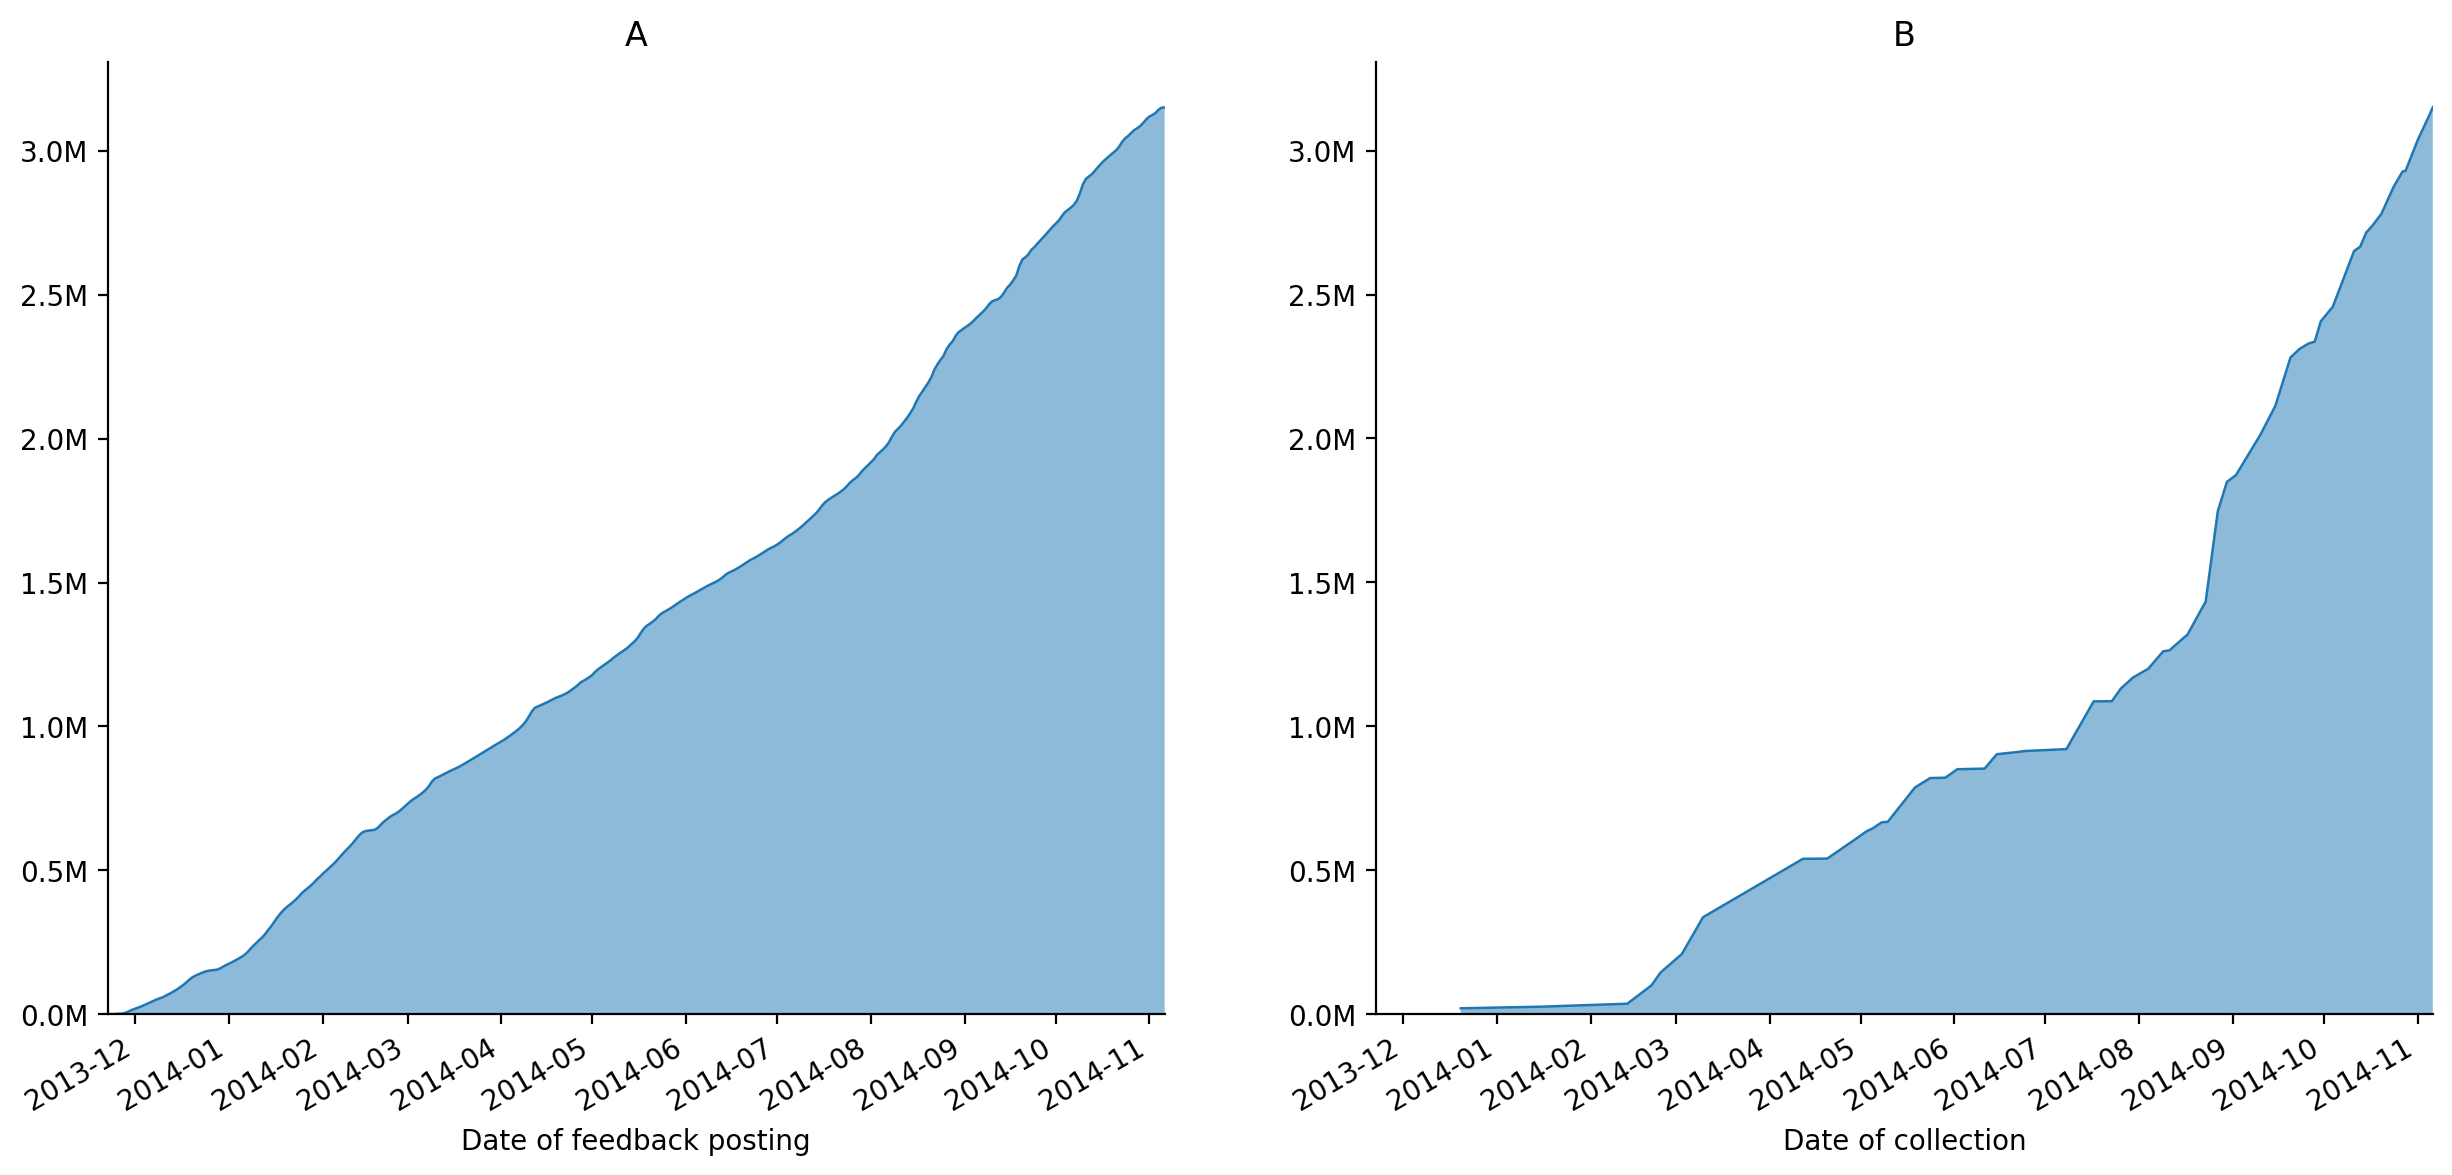

In [34]:
def millions(x, pos):
    return'{:,.1f}M'.format(x*1e-6)

fmt = mpl.ticker.FuncFormatter(millions)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 7))

#make cum_dist plot rating time (left)
df\
    .assign(rtime_dt = df['rtime_dt'].dt.date)\
    .groupby('rtime_dt')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax1, linewidth = .9)
ax1.set_ylim(bottom = 0)
ax1.yaxis.set_major_formatter(fmt)
ax1.set_xlim(t_min, t_max)
ax1.set_title('A')

#fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_xlabel('Date of feedback posting')


# make cum_dist plot scrape time (right)
df\
    .groupby('stime_dt')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax2, linewidth = .9)
ax2.set_ylim(bottom = 0)
ax2.yaxis.set_major_formatter(fmt)
ax2.set_xlim(t_min, t_max)
ax2.set_title('B')

#fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_xlabel('Date of collection')

fig.autofmt_xdate()
plt.show()

The plots above show the cumulative distribution of sample size by rating time (left: `rtime`) and scrape time (right: `stime`). 

#### Cumulative distribution of feedback postings
The left subplot show that the feedbacks posted in our sample are posted gradually over time. This reflects a natural growth distribution of feedback postings in the collected sample. This indicates that the scraping process of the data has proceeded quite reliably. 

#### Cumulative sample size make up per scrape
On the right subplot shows an increasing growth of sample size, which is an inherent characteristic of scraped data. Scrapes at later time points might collect data points that were overlooked in previous scrapes. 

In [35]:
s_max = df['stime_str'].max()
s_min = df['stime_str'].min()
s_frq = ((s_max - s_min) / len(df.stime_str.unique())).days

print("The data was collected once every {0} days between {1} and {2}"\
      .format(s_frq, s_min.strftime(format = "%B %d %Y"), s_max.strftime(format = "%B %d %Y")))
print("Within this timespan {0} unique transactions were observed, from a total of {1} unique sellers"\
      .format(len(df), len(df.vendor.unique())))

The data was collected once every 5 days between December 20 2013 and November 06 2014
Within this timespan 3151032 unique transactions were observed, from a total of 1232 unique sellers


In [36]:
drugs_trans = len(df.loc[df['category'].str.contains('drugs')])
total_trans = len(df)

drugs_vendor = df.loc[df['category'].str.contains('drugs')]['vendor'].nunique()
drugs_items = df.loc[df['category'].str.contains('drugs')]['item'].nunique()

print(drugs_trans, total_trans, drugs_trans/total_trans)
print(drugs_vendor, drugs_items)


2952596 3151032 0.9370250762289942
1221 28191


# Data Selection

In [37]:
# create time difference between sales for sellers
df = df.sort_values('rtime_dt')
df['t'] = df\
    .assign(rtime_dt = df['rtime_dt'])\
    .groupby('vendor')['rtime_dt']\
    .transform(lambda x: (x - x.min()).dt.days)


# creates time variables for sellers
df = df.sort_values(['vendor', 'rtime_dt'])
df['count'] = df.groupby(['vendor']).cumcount()
df = df.sort_values(['vendor', 'rtime_dt'])
df['cum_count'] = df.groupby('vendor')['vendor'].transform(np.size)

In [38]:
# drop vendors that have insufficient market activity
has_period = df\
    .groupby('vendor')['t']\
    .max()\
    .apply(lambda x: x > 14)

has_sales_volume = df\
    .groupby('vendor')['count']\
    .max()\
    .apply(lambda x: x > 20)

market_opening = df.rtime_dt.min()
has_early_market_entry = df.groupby('vendor')\
    .apply(lambda x: (1 + (x.rtime_dt - market_opening).dt.days // 7))\
    .reset_index()\
    .groupby('vendor')['rtime_dt']\
    .min().apply(lambda x: x <=35)

In [39]:
# store initial sample 
N_ = df.shape[0]

# select cases
df = df\
    .loc[df['category'].str.contains('drugs')]

# store selected sample
N_drugs = df.shape[0]
k_drugs = df['vendor'].nunique()
  
# select seller with valid period and volume
df = df\
    .loc[(df['vendor'].map(has_period))\
         & (df['vendor'].map(has_sales_volume))
         & (df['vendor'].map(has_early_market_entry))]

N_final = df.shape[0]
k_final = df['vendor'].nunique()
p_final = df['item'].nunique()

print('Initial sample: ', N_, 
    '\nDrugs sample  : ', N_drugs,
    '\nDrugs sellers : ', k_drugs,
    '\nFinal:          ', N_final,
    '\nFinal sellers : ', k_final)

Initial sample:  3151032 
Drugs sample  :  2952596 
Drugs sellers :  1221 
Final:           2815399 
Final sellers :  925


In [40]:
p_final = df['item'].nunique()
p_final

24778

## Bitcoin Conversion information

In [41]:
# scrape Bitcoin data
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130429&end=20200212"

bitcoin_data = pd.read_html(url)[2]
bitcoin_data.columns =  map(str.lower, bitcoin_data.columns)

In [42]:
bitcoin_data = bitcoin_data[['date', 'open*', 'high', 'low', 'close**']]\
    .assign(date = pd.to_datetime(bitcoin_data['date']),
            mean = bitcoin_data[['high', 'low']].mean(axis=1))\
    .sort_values('date')\
    .reset_index(drop = True)

# define observation period
observation_period = (bitcoin_data['date'] > t_min)\
                      & (bitcoin_data['date'] < t_max)

max_bit = bitcoin_data[observation_period]['mean'].max()
min_bit = bitcoin_data[observation_period]['mean'].min()

In [43]:
bitcoin_data.head()

date   open*    high     low  close**     mean
0 2013-04-29  134.44  147.49  134.00   144.54  140.745
1 2013-04-30  144.00  146.93  134.05   139.00  140.490
2 2013-05-01  139.00  139.89  107.72   116.99  123.805
3 2013-05-02  116.38  125.60   92.28   105.21  108.940
4 2013-05-03  106.25  108.13   79.10    97.75   93.615

### Fluctiations in bitcoin price

Bitcoin infamously known for its price flucuations. Although the window of observation of this study is way beyond the "bitcoin bubble" occured, there were considerable changes in bitcoin prices overtime.  {{max_bit}}

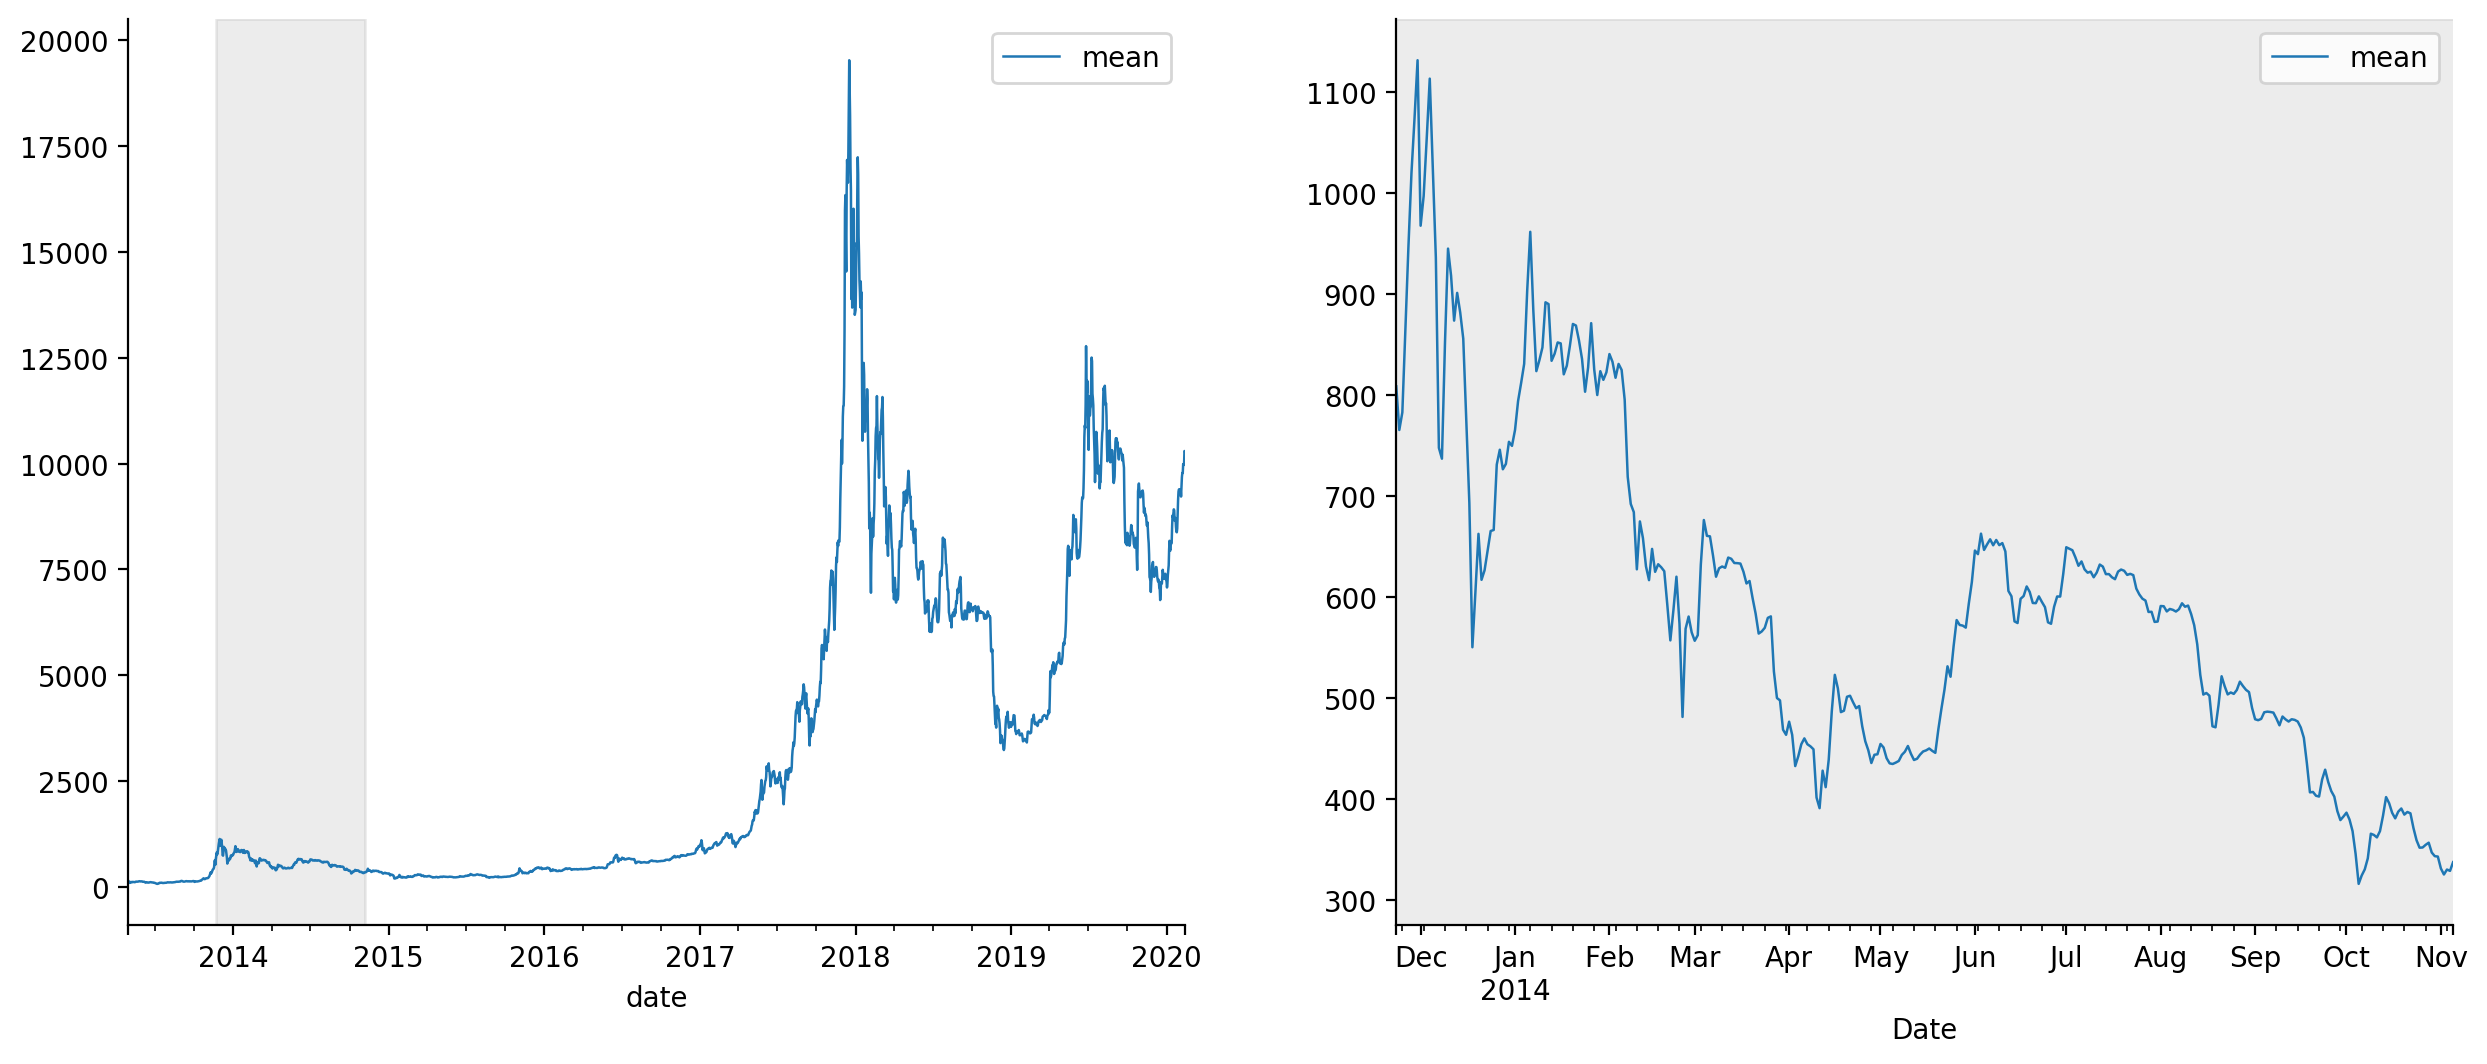

In [44]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 6))

# all time
bitcoin_data.plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax1
)

ax1.axvspan(t_min, t_max, color='grey', alpha=0.15)
ax2.set_xlabel('Date')

# time window of observations
bitcoin_data.loc[observation_period].plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax2
)

ax2.axvspan(t_min, t_max, color='grey', alpha=0.15)
ax2.set_xlabel('Date')

plt.show()

## Converting bitcoin to USD

To make the prices comparable over time points we convert te bitcoin prices to USD. 

In [45]:
# make covertion dictionary
rates = bitcoin_data\
    .assign(date = bitcoin_data['date'])\
    .set_index('date')['mean']\
    .to_dict()

# convert bitcoins to usd
df = df\
    .assign(price_usd = df['rtime_dt'].map(rates) * df['price'])

In [46]:
# assert values are not 'inf'
valid_range = (~df['price_usd'].isin([np.nan, np.inf, -np.inf]))\
               & (df['price_usd'] >= 0)

df['price_usd'] = df['price_usd'].mask(~valid_range)

# mark selling prices higher than 100000 as out of stock
df = df.assign(empty_stock = df['price_usd'] >= 10**4)

562


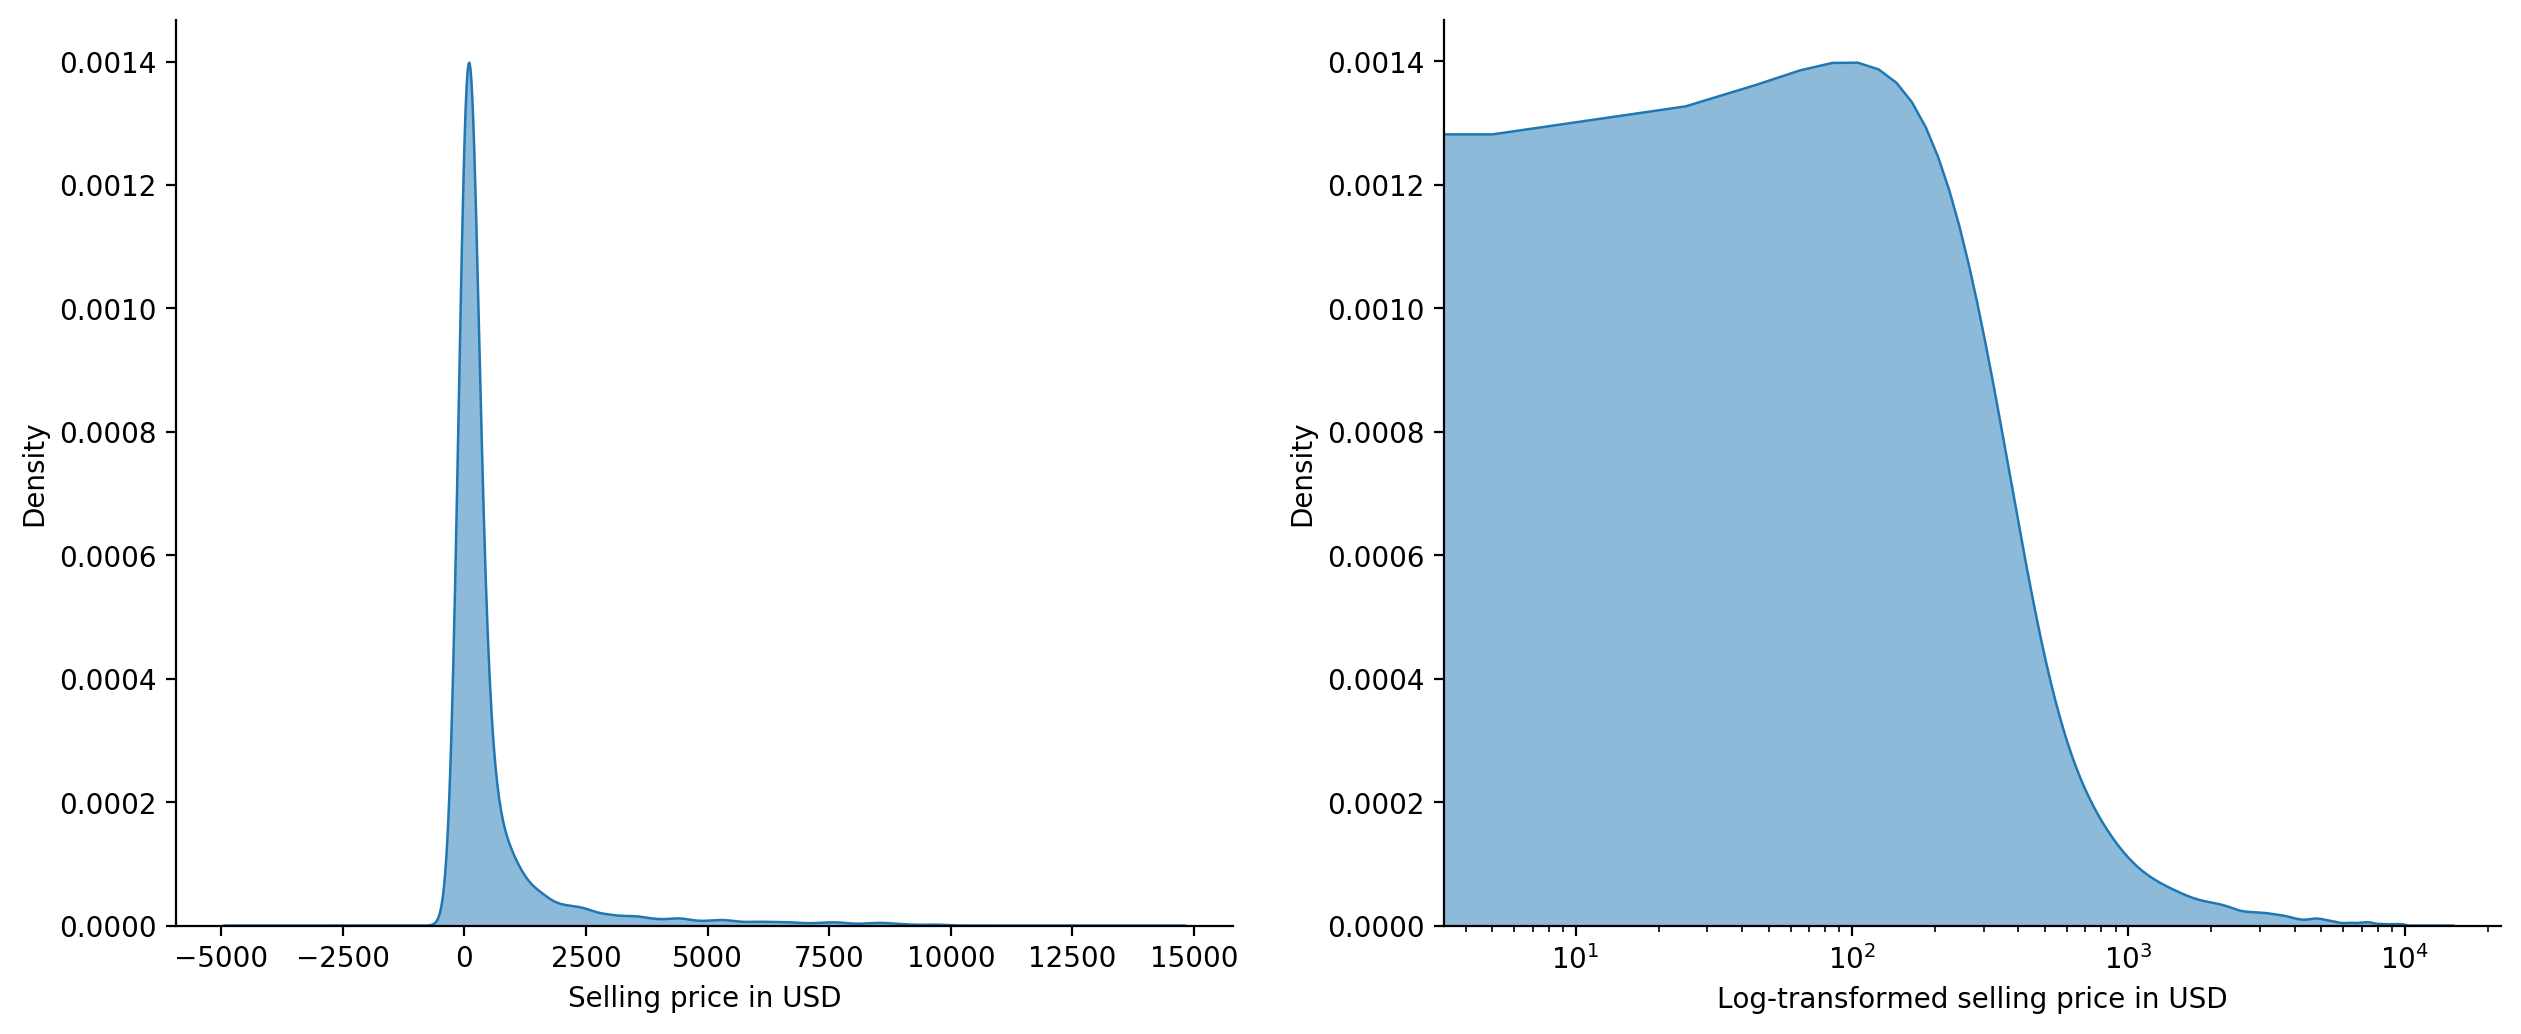

In [47]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

# plot not transformed price (right)
df['price_usd'][valid_range & (df['empty_stock'] == False)]\
    .sample(10000)\
    .dropna()\
    .plot.kde(linewidth = .9, ax = ax1)

# fill density plot (right)
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlabel('Selling price in USD')

# plot log transformed price (left)
df['price_usd'][valid_range & (df['empty_stock'] == False)]\
    .sample(10000)\
    .dropna()\
    .plot.kde(linewidth = .9, ax = ax2)

# fill density plot (left)
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set_xscale('log')
ax2.set_xlabel('Log-transformed selling price in USD')

# asses attriation due to invalid values
k_org = len(df['price_usd'][~df['price_usd'].isin([np.nan, np.inf, -np.inf])])
k_val = len(df['price_usd'][valid_range])
print(k_org - k_val)

plt.show()

The prices of products on *silkroad2* are extremely right skewed. Top tier prices range in USD +100,000. `log`-transformation helps to normalized selling prices considerably. Prices higher than USD 100,000 are considered outliers and are therefore excluded from the data. There by 24497 observations were coded as missing, which can be explained by: 
- missingness on the price variable
- `inf` value on the price value
- missingness on data value

## Rating Time

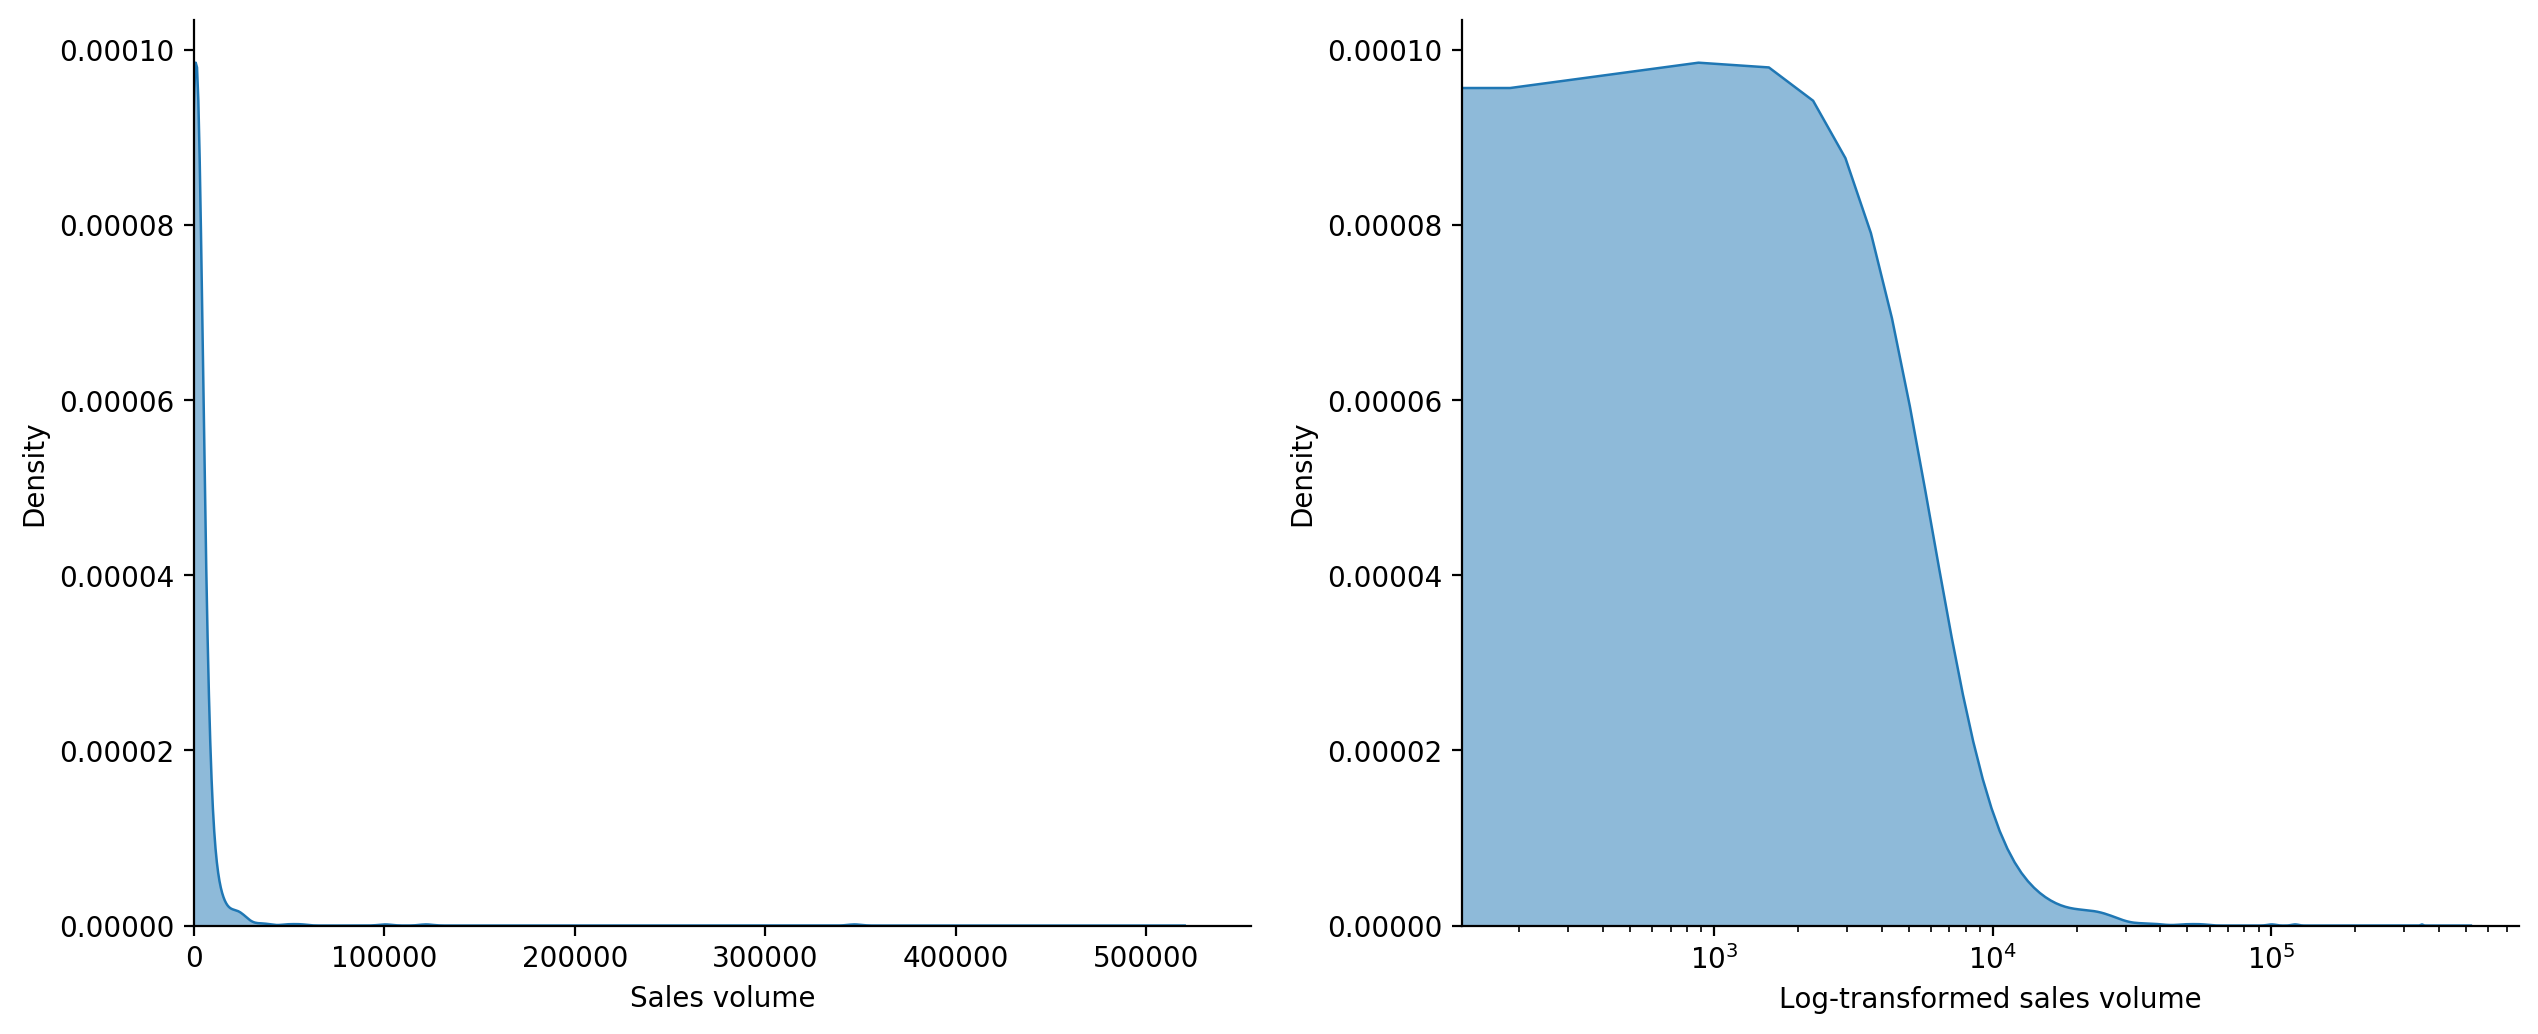

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# plots density distribution for sale volume (left)
df['vendor'].value_counts().plot.kde(ax = ax1, linewidth = .9)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = -50)
ax1.set(xlabel = 'Sales volume')

# plots density distribution for log-transformed sales volume (right)
df['vendor'].value_counts().plot.kde(ax = ax2, linewidth = .9)
ax2.set_xscale('log')

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set(xlabel = 'Log-transformed sales volume')

plt.show()

The graphs above displays the cumulative sales over time for each seller that had more than 20 sales in the observed period. The left panel displays the logmarithmically transformed sales trajectories over time. The right panel shows the proportional increase in sales over the proportion of time that the seller as pressent on the market. 

## Artificial Reputation Formation

In [49]:
def f(x):
    x['diff'] = x['t']-x['t'].shift(1)
    return x

df = df.sort_values(['vendor', 't'])

# calculates time difference between sales
df['diff'] = df\
    .groupby('vendor')\
    .apply(f)['diff']\
    .fillna(1)\
    .sort_index()

# drop existing column
if 'delta_t' in df:
    df = df.drop('delta_t', axis = 1)

# creates look-up table with delta_t column
df = df.sort_values(['vendor', 't'])
col = df['diff']\
    .groupby([df['vendor'], df['t']])\
    .apply(lambda x: x.mean())\
    .reset_index()\
    .rename(columns = {'diff' : 'delta_t'})
    
# merges delta_t on dataframe
df = pd.merge(df, col, on = ['vendor', 't'])

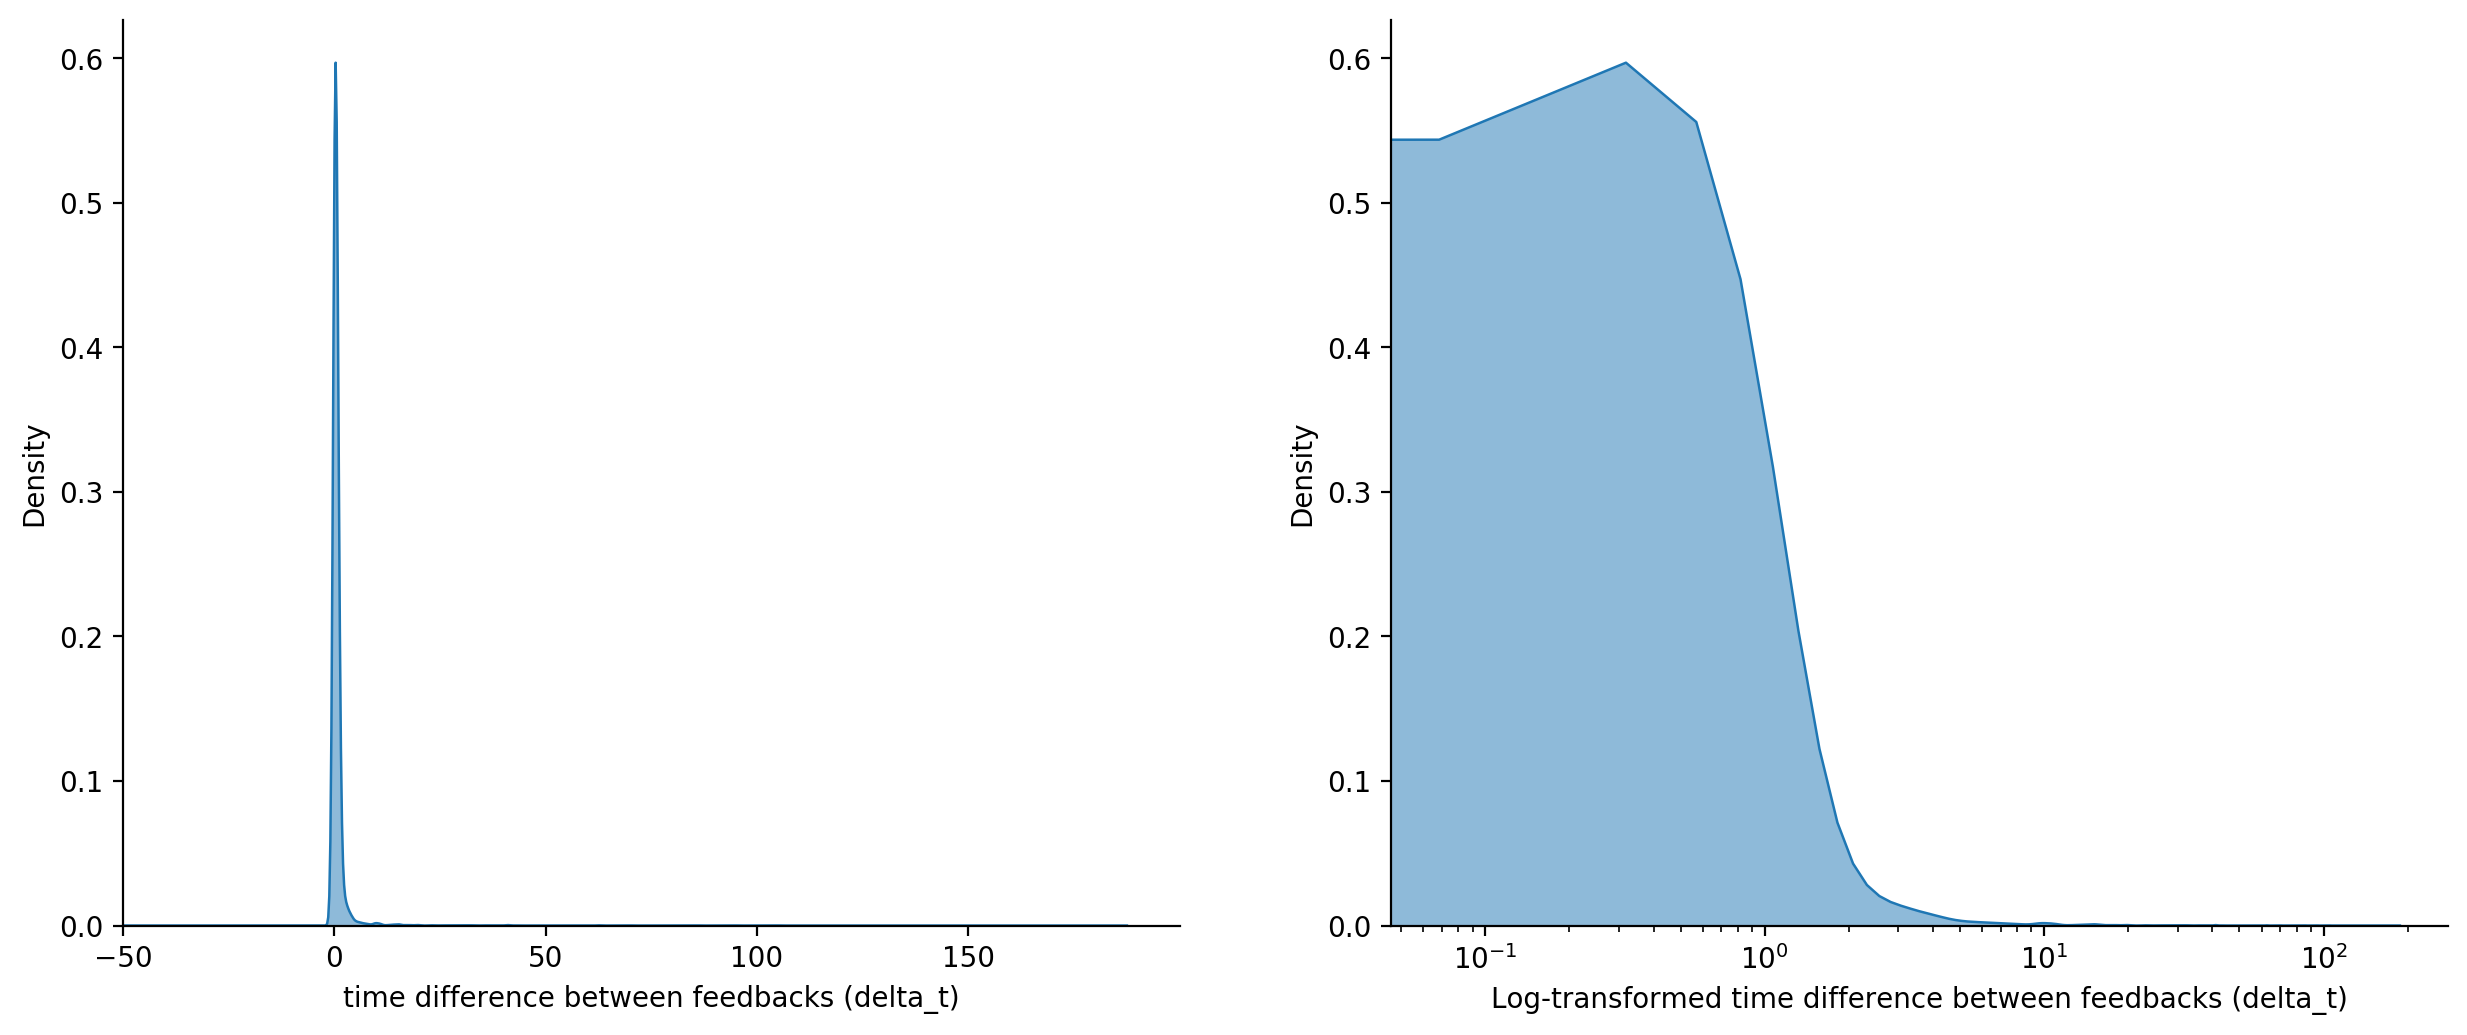

In [50]:
market_entry = (df['count'] <= 10) & (df['empty_stock'] == False)

# set plotting areas
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# make distribution plot w/o transformation (left)
df[market_entry]['delta_t'].plot.kde(ax = ax1, linewidth = .9)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# set axes
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = -50)
ax1.set(xlabel = 'time difference between feedbacks (delta_t)')

# make distribution plot with log transformation (right)
df[market_entry]['delta_t'].plot.kde(ax = ax2, linewidth = .9)
ax2.set_xscale('log')

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# set axes
ax2.set_ylim(bottom = 0)
ax2.set(xlabel = 'Log-transformed time difference between feedbacks (delta_t)')

plt.show()

The plots above present the density distributions of time difference between posted feedbacks. As expected, these distributions are extremely left skewed. **cut-off values need to be determined to excluded univariate outliers**

### Decision Rule for ARF

In [51]:
# setting cut of values
t_cut = df[market_entry]['delta_t'].quantile(1/3)
p_cut = df[market_entry]['price_usd'].quantile(1/2)
s_cut = df[market_entry].groupby('vendor')['delta_t'].std().quantile(1/3)

# drop existing column
if 'arf' in df: 
    df = df.drop('arf', axis = 1)

# ARF 1
col = df[market_entry]\
    .groupby('vendor')\
    .apply(lambda x: (x['delta_t'].mean() < t_cut\
                      and (x['price_usd'].mean() < p_cut)\
                      and (x['delta_t'].std() < s_cut)))\
    .rename('arf')

df = df.merge(col, on = 'vendor')

In [52]:
names = ['s_cut(entry)', 't_cut(entry)', 'p_cut(entry)']
cuts  = [ s_cut,   t_cut,   p_cut]

for n, c in zip(names, cuts):
    print(n, round(c, 3))

s_cut(entry) 0.176
t_cut(entry) 0.2
p_cut(entry) 139.695


In [53]:
len(df[df['arf'] == True]['vendor'].unique())

43

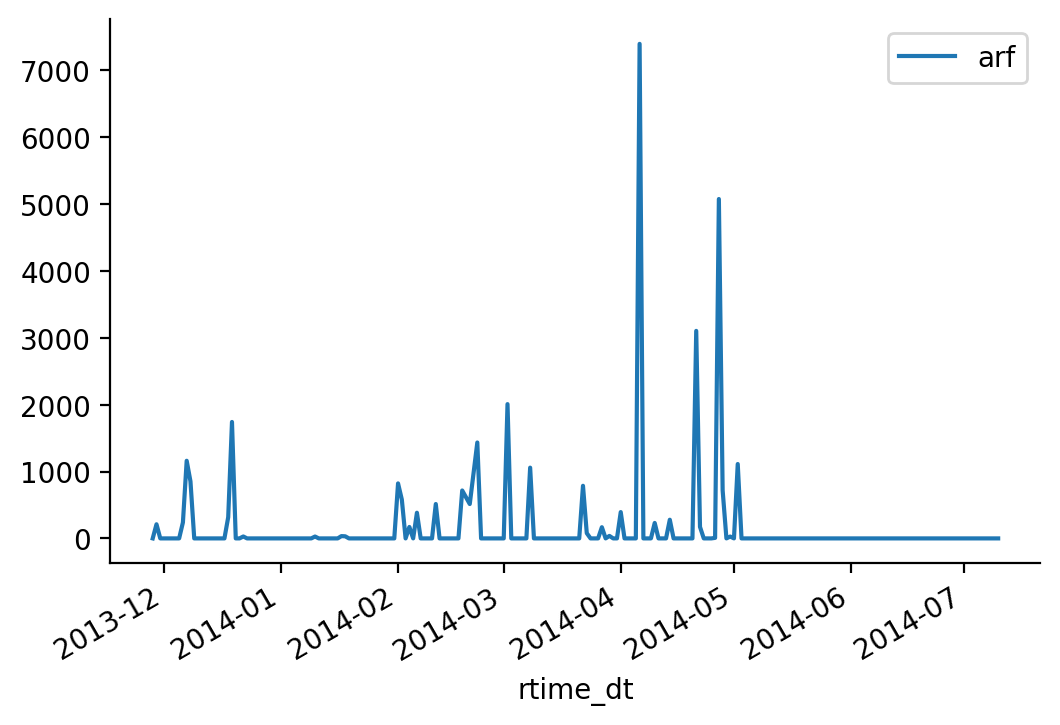

In [54]:
df.groupby('vendor')[['arf', 'rtime_dt']].sum().reset_index(drop = True).groupby(df['rtime_dt']).mean().plot()

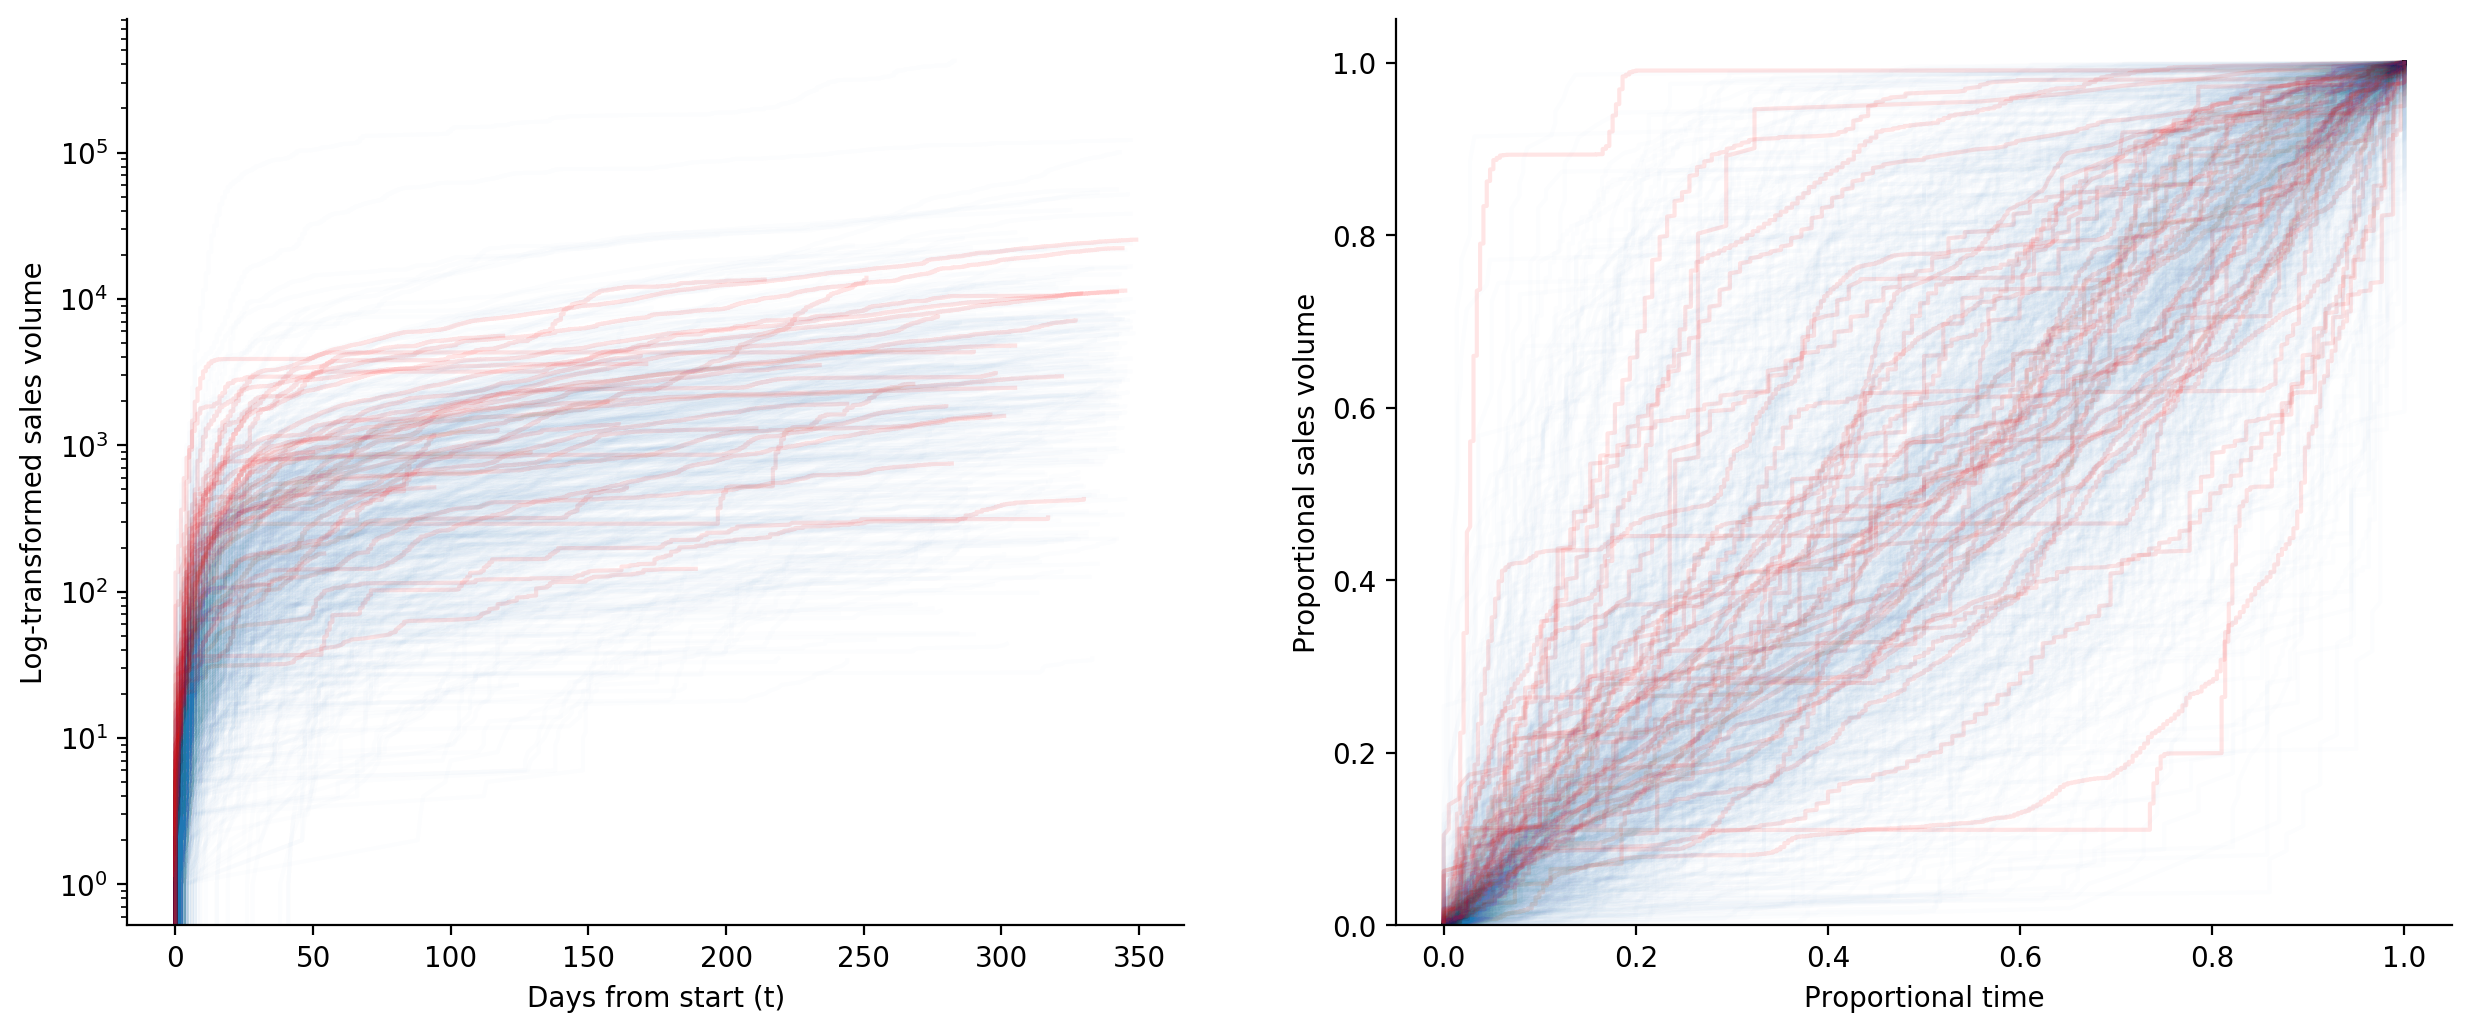

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]

vendors = df_['vendor'].unique().tolist()
colors = {True  : 'red',
          False : '#1f77b4'}
alphas = {True  : .10,
          False : .01}

# iterative plotting for sales trajectory of cryptosellers
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't', 'arf']].dropna()
    y = v['count'].astype(int).sort_values()
    x = v['t'].astype(int).sort_values()
    c = v['arf'].map(colors).to_list()[0]
    a = v['arf'].map(alphas).to_list()[0]
    
    # Plots sales trajectory 
    ax1.plot(x, y, alpha = a, c = c)
    ax1.set_yscale('log')
    ax1.set(xlabel = 'Days from start (t)',
            ylabel = 'Log-transformed sales volume')
    
    y = y / v['count'].max()
    x = x / v['t'].max()
    
    # Plots proportional sales trajectory
    ax2.plot(x, y, alpha = a, c = c)
    ax2.set_ylim(bottom = 0)
    ax2.set(xlabel = 'Proportional time',
            ylabel = 'Proportional sales volume')

# display plot
plt.show()

### Latent Class Analysis for ARF

In [56]:
std = df[df['count'] <= 10]\
    .reset_index(drop = True)\
    [['vendor', 't', 'delta_t']]\
    .groupby('vendor')\
    .std()\
    .add_suffix('_s')

mean = df[df['count'] <= 10]\
    .reset_index(drop = True)\
    [['vendor', 't', 'price_usd', 'delta_t']]\
    .groupby('vendor')\
    .mean()\
    .add_suffix('_m')

vendor_ = df[df['count'] <= 10]\
    [['vendor', 'arf']]\
    .groupby('vendor')\
    .mean()\
    .reset_index()
    
features = pd.concat([std, mean], axis = 1)\
    .reset_index(drop = True)\
    .fillna(0)\
    .drop(['t_m', 't_s'], axis = 1)

cols = features.columns

In [57]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn import mixture, cluster

features = power_transform(features, method = 'yeo-johnson')

# configure LCA algorithms
bgm = mixture.BayesianGaussianMixture(
    n_components = 2, 
    covariance_type = 'full',
    max_iter = 300)

birch = cluster.Birch(
    n_clusters = 2)

# fit and predict results
arf_bgm = pd.Series(bgm.fit_predict(features), name = 'arf_bgm')
arf_birch = pd.Series(birch.fit_predict(features), name = 'arf_birch')

# concat results into a matrix
result = pd.concat([arf_birch, arf_bgm, pd.DataFrame(features, columns = ['t_s', 'p_m', 't_m'])], axis = 1)

In [58]:
result.arf_bgm.value_counts()

0    787
1    118
Name: arf_bgm, dtype: int64

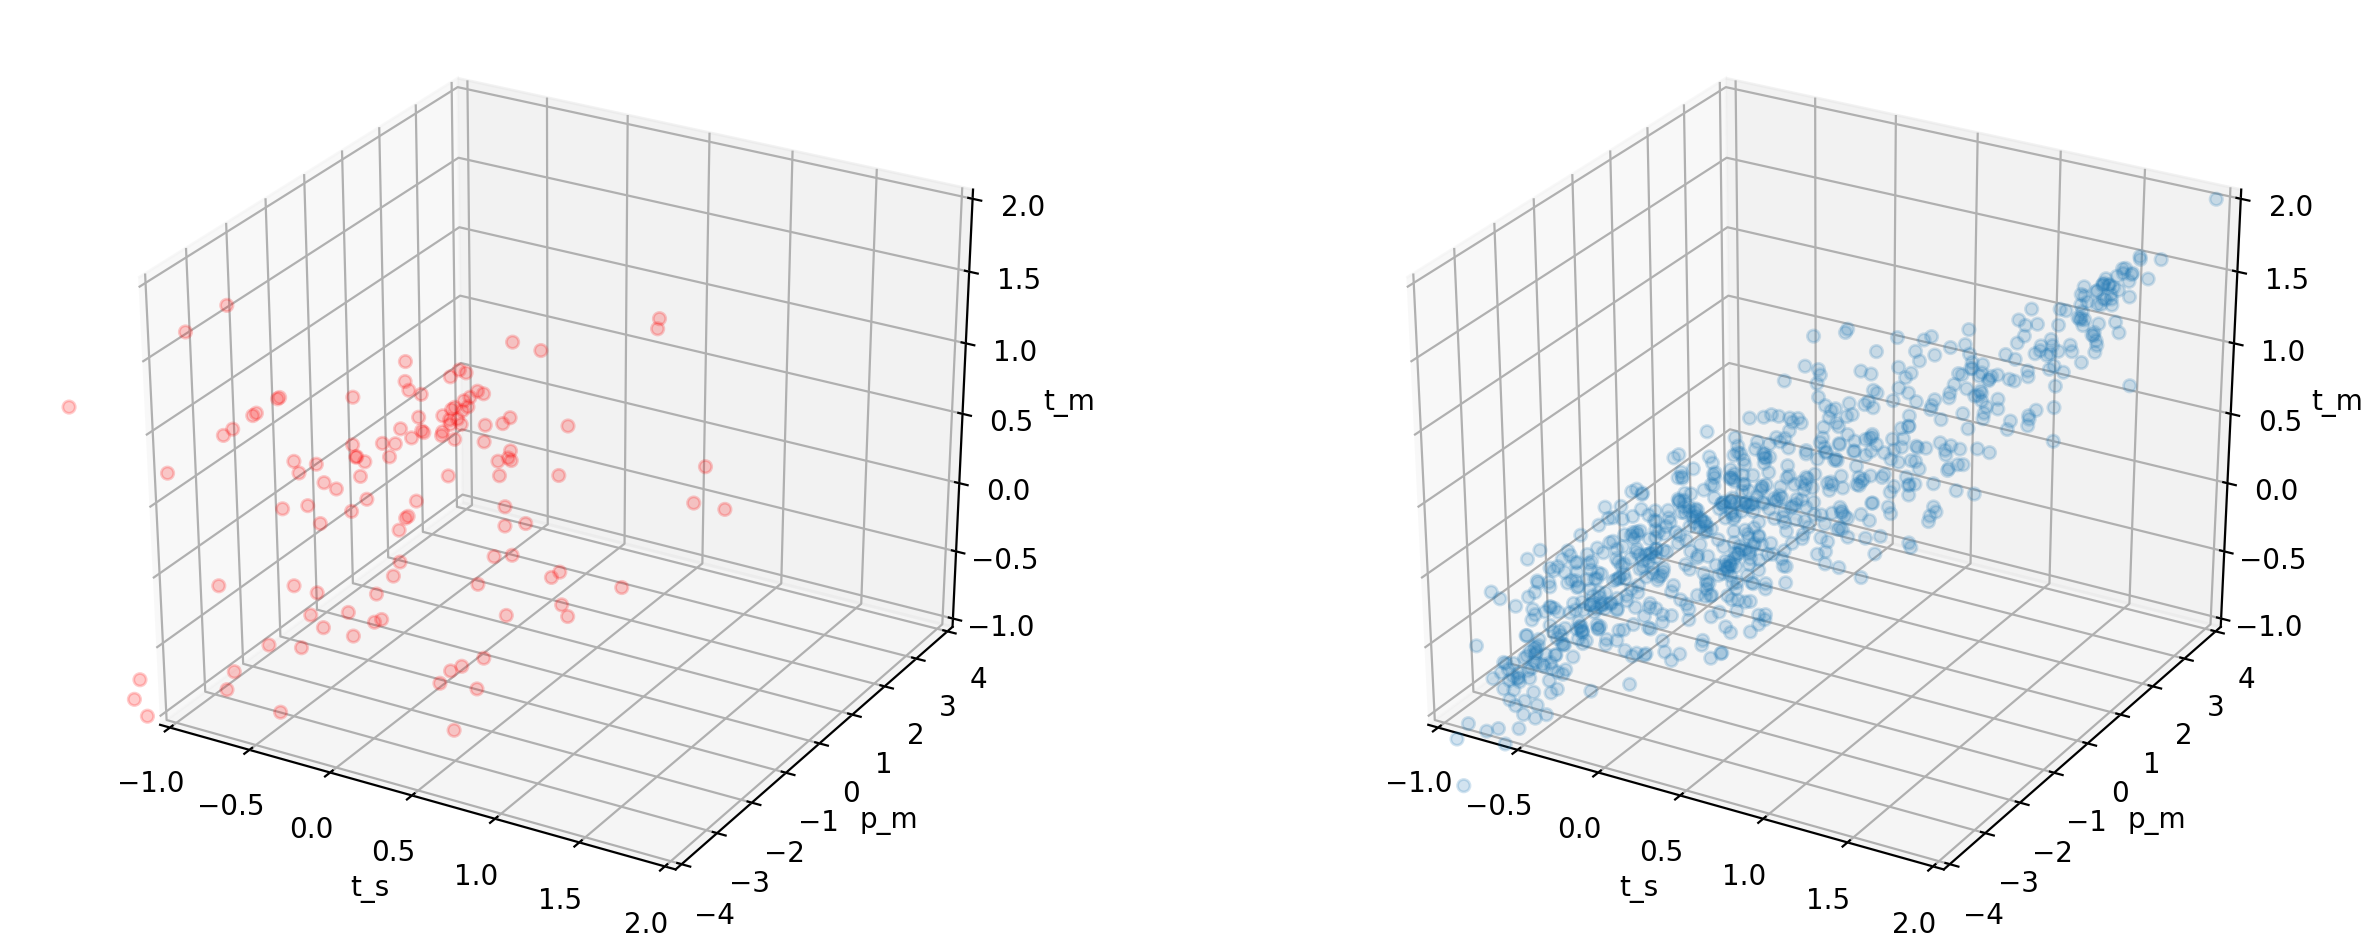

In [59]:
# Visual Inspection of ARM
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

p_d = result.copy()

# # censor ARM classfied products with a to high price
# result.loc[p_d['p_m'] > 0, 'arf_bgm'] = 3
# p_d.loc[p_d['p_m'] > 0, 'arf_bgm'] = 3

# set arm condition
arf = p_d['arf_bgm'] == 1

# plot LCA structure
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(xs = p_d[arf].t_s,
            ys = p_d[arf].p_m, 
            zs = p_d[arf].t_m,
            c  = 'red',
            alpha = .2)

ax1.set_xlim(-1, 2)
ax1.set_ylim(-4, 4)
ax1.set_zlim(-1, 2)

ax1.set_xlabel('t_s')
ax1.set_ylabel('p_m')
ax1.set_zlabel('t_m')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(xs = p_d[~arf].t_s,
            ys = p_d[~arf].p_m, 
            zs = p_d[~arf].t_m,
            c  = '#1f77b4',
            alpha = .2)

ax2.set_xlim(-1, 2)
ax2.set_ylim(-4, 4)
ax2.set_zlim(-1, 2)

ax2.set_xlabel('t_s')
ax2.set_ylabel('p_m')
ax2.set_zlabel('t_m')

plt.show()

In [60]:
if 'arf_bgm' in df: 
    df = df.drop('arf_bgm', axis = 1)
    
# merge result
df = df.merge(pd.concat([vendor_, result['arf_bgm']], axis = 1), on = ['vendor', 'arf'])\
    .assign(arf_bgm = lambda x: x['arf_bgm'].map({0 : False, 1 : True}))

In [61]:
df[df['arf_bgm'] == True]['vendor'].nunique()

118

In [62]:
vendors = df\
    .groupby('vendor')\
    [['arf', 'arf_bgm']]\
    .max()

stats.chi2_contingency(pd.crosstab(vendors.arf, vendors.arf_bgm))

(0.1718605378523483,
 0.6784635547413049,
 1,
 array([[749.60662983, 112.39337017],
        [ 37.39337017,   5.60662983]]))

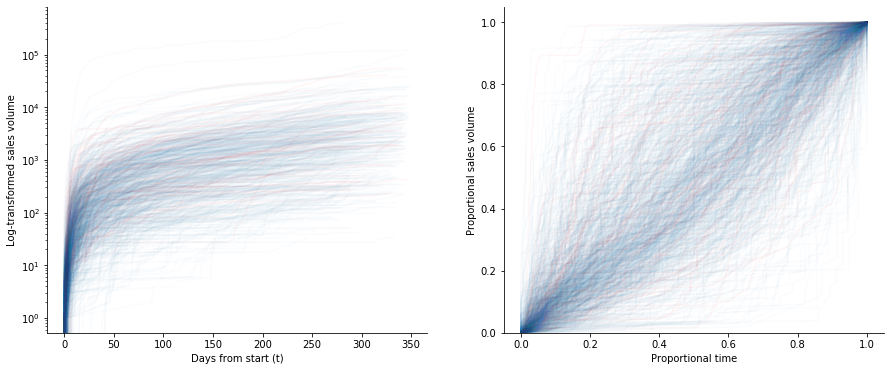

In [74]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]

vendors = df_['vendor'].unique().tolist()
colors = {True  : 'red',
          False : '#1f77b4'}
alphas = {True  : .03,
          False : .02}

# iterative plotting for sales trajectory of cryptosellers
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't', 'arf_bgm']].dropna()
    y = v['count'].astype(int).sort_values()
    x = v['t'].astype(int).sort_values()
    c = v['arf_bgm'].map(colors).to_list()[0]
    a = v['arf_bgm'].map(alphas).to_list()[0]
    
    # Plots sales trajectory 
    ax1.plot(x, y, alpha = a, c = c)
    ax1.set_yscale('log')
    ax1.set(xlabel = 'Days from start (t)',
            ylabel = 'Log-transformed sales volume')
    
    y = y / v['count'].max()
    x = x / v['t'].max()
    
    # Plots proportional sales trajectory
    ax2.plot(x, y, alpha = a, c = c)
    ax2.set_ylim(bottom = 0)
    ax2.set(xlabel = 'Proportional time',
            ylabel = 'Proportional sales volume')

# display plot
plt.show()

## Negative Ratings

In [63]:
(df['rating'] == 5).mean()

0.9715459813520503

In [64]:
df = df.sort_values(['vendor','count']).reset_index(drop = True)

# cumulative count of negative feedbacks per vendor
df['neg_count'] = df\
    .assign(neg = df['rating'] != 5)\
    .groupby('vendor')['neg']\
    .cumsum()\
    .reset_index(drop = True)\
    .rename('neg_count') + 1

df = df.sort_values(['vendor','count']).reset_index(drop = True)
# cumulative count of positive feedbacks per vendor
df['pos_count'] = df\
    .assign(pos = df['rating'] == 5)\
    .groupby('vendor')['pos']\
    .cumsum()\
    .reset_index(drop = True)\
    .rename('pos_count') + 1

In [65]:
# cumulative proportion of negative feedbacks per vendor
df['neg_rating'] = df['neg_count'] / (df['count'] + 1)

## Artificial Reputation Maintenance

In [66]:
not_market_entry = (df['count'] > 10) & (df['empty_stock'] == False)

# time fixed cut-offs
t_cut = df[not_market_entry]['delta_t'].quantile(1/3)
p_cut = df[not_market_entry]['price_usd'].quantile(1/2)
s_cut = df[not_market_entry].groupby('vendor')['delta_t'].std().quantile(1/3)

### Visual inspection of temporal fluctuation in cut-offs

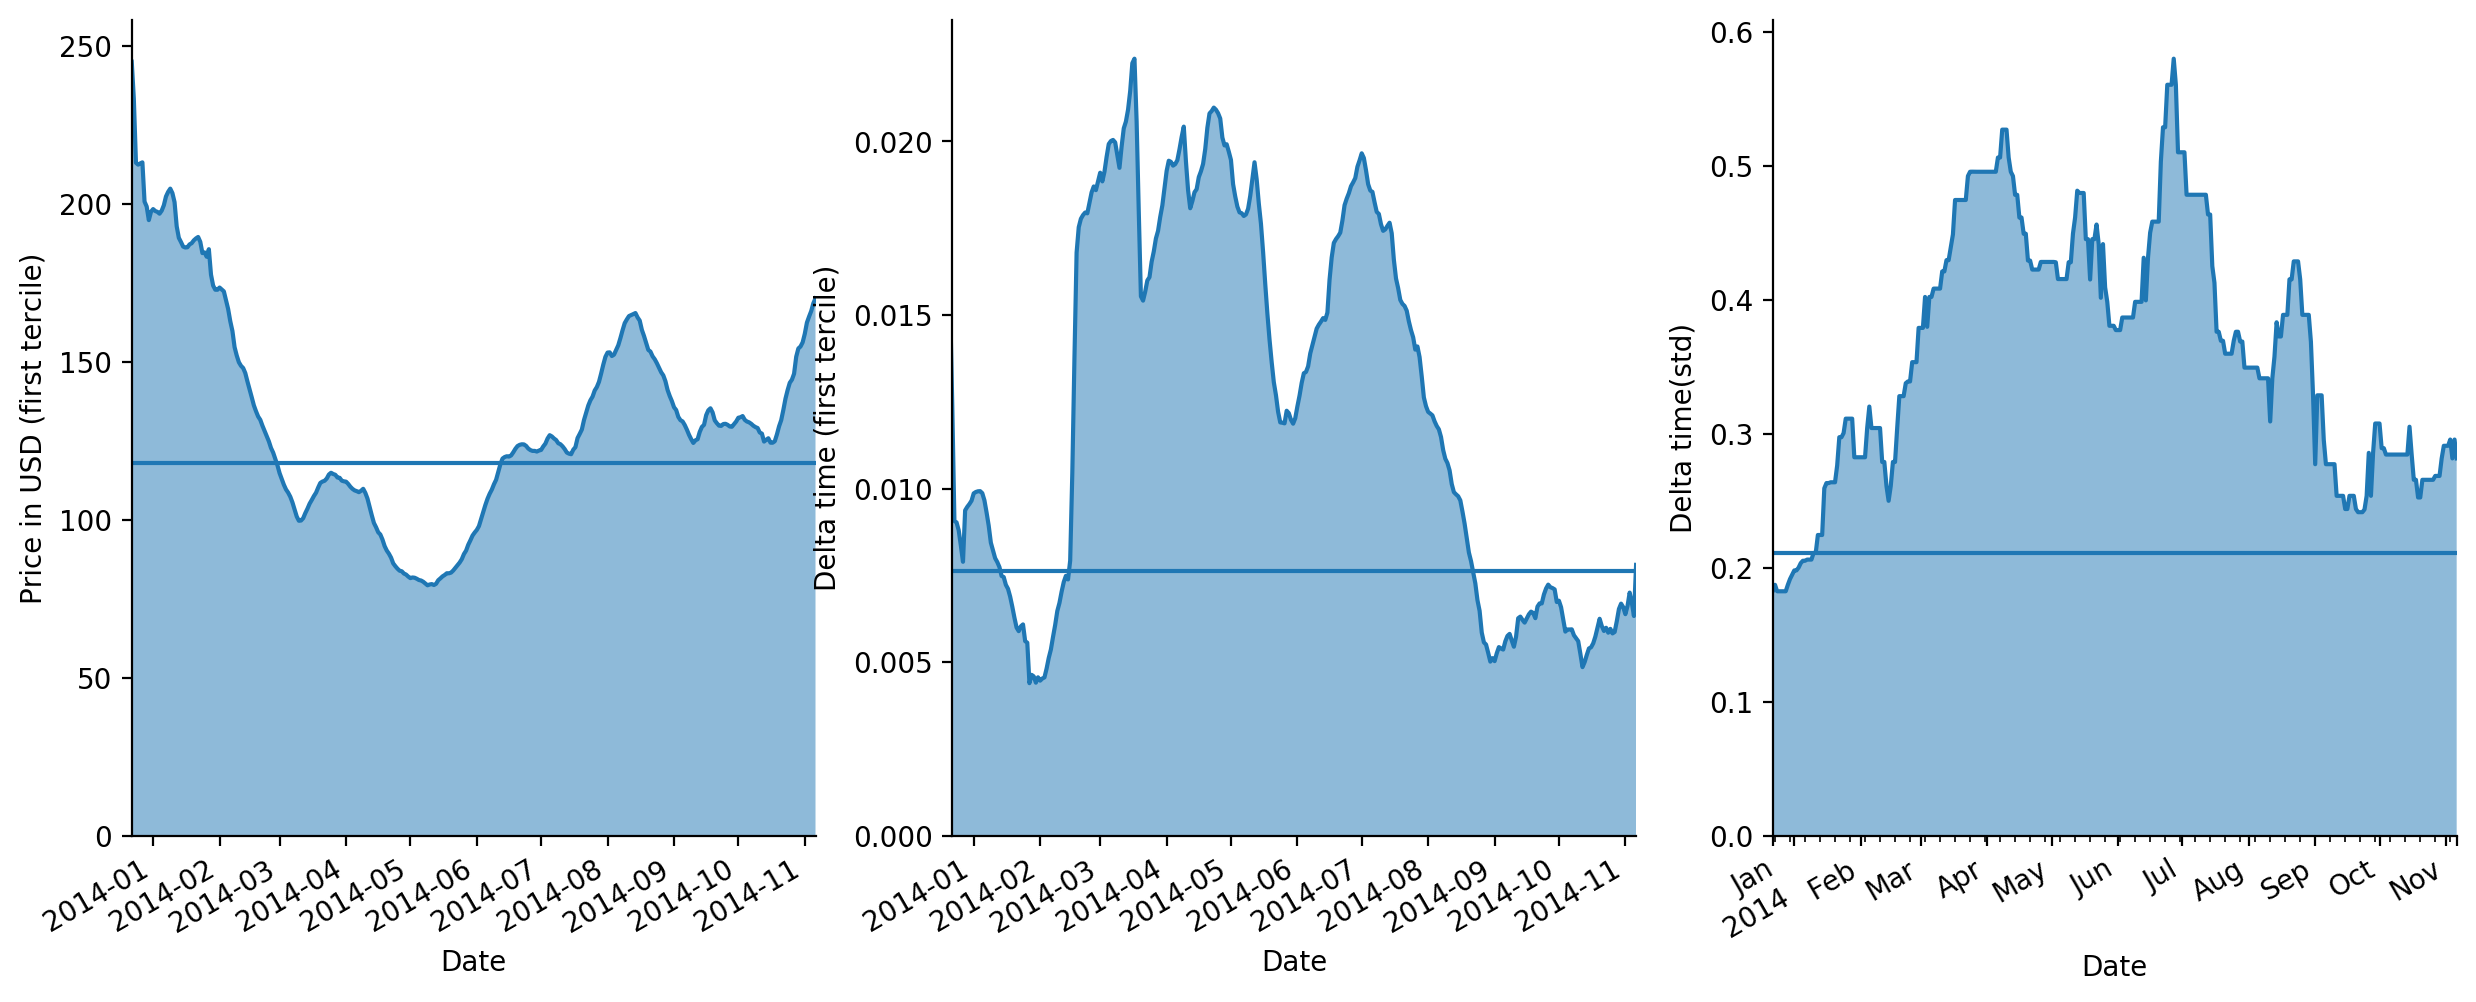

In [67]:
# offset minimum time
nt_min = t_min + pd.DateOffset(days = 30)

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = [15,6])

# plot price fluctuation over time (left)
df\
    .groupby(df['rtime_dt'].dt.date)['price_usd']\
    .quantile(1/2)\
    .rolling(30)\
    .mean().plot(ax = ax1)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal lines
ax1.axhline(y = p_cut)

# set axes
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = nt_min, right = t_max)
ax1.set(xlabel = 'Date',
        ylabel = 'Price in USD (first tercile)')

# plot delta_t fluctuations over time (middle)
df\
    .groupby(df['rtime_dt'].dt.date)['delta_t']\
    .quantile(1/3)\
    .rolling(30)\
    .mean().plot(ax = ax2)

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal line
ax2.axhline(y = t_cut)

# set axes
ax2.set_ylim(bottom = 0)
ax2.set_xlim(left = nt_min, right = t_max)
ax2.set(xlabel = 'Date',
        ylabel = 'Delta time (first tercile)')

# plot delta_t fluctuations over time (middle)
df\
    .groupby(df['rtime_dt'].dt.normalize())['delta_t']\
    .std()\
    .rolling(30)\
    .quantile(1/3).plot(ax = ax3)

# fill graph
line = ax3.lines[0].get_data()
ax3.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# horizontal line
ax3.axhline(y = s_cut)

# set axes
ax3.set_ylim(bottom = 0)
ax3.set_xlim(left = nt_min, right = t_max)
ax3.set(xlabel = 'Date',
        ylabel = 'Delta time(std)')

fig.autofmt_xdate()
plt.show()

The plots above show the temporal variation in price (first tercile) and time (first quartile) cut-offs. The plots indicate that there are considerably fluctuations in both price and time gaps during market entry over time. The temporal differences in time gaps are to be interpreted in the light of increases and decreases of demand and supply. 

In conclusion to the visual inspection of the temporal differences in time and price cut-offs over time we deem that the time constant cut-offs suffice.

### Decision Rule for ARM

In [68]:
# sort data frame
df = df.sort_values(['vendor', 'rtime']).reset_index(drop = True)

# calculate ARM
df['arm'] = df\
    .groupby(['vendor'])\
    [['delta_t', 'price_usd', 'rating', 'count']]\
    .rolling(10)\
    .mean()\
    .reset_index()\
    .assign(t_low = lambda x: x['delta_t'] < t_cut,
            p_low = lambda x: x['price_usd'] < p_cut,
            after_market_entry = lambda x: x['count'] > 10)\
    .assign(arm = lambda x: (x[['t_low', 'p_low', 'after_market_entry']].all(axis = 1)))['arm']

In [69]:
df.loc[df['count'] <= 10, 'arm'] = None

In [70]:
# 
df['arm'] = df['arm'].map({0 : False, 1 : True})

print(df['arm'].value_counts())

False    2458674
True      302959
Name: arm, dtype: int64


### Latent Class Analysis for ARM

Will be calculated after aggregation 

## Control Variables

### Ships internationally

In [71]:
df = df\
    .assign(
        location = df['location'].replace('unknown', 'Undeclared').astype('category'),
        area = df['area'].replace('unknown', 'Undeclared').astype('category'))

df['international_shipment'] = df['location'].astype(str) != df['area'].astype(str)

### Category

In [72]:
cat = df['category'].str.lower()\
    .str.replace('drugs-', '')\
    .str.replace('intoxicants-', '')

In [73]:
cat.loc[cat.str.count('-') == 0 & cat.str.contains('drugs')] = 'unknown-unknown-unclassified'
cat[cat.str.count('-') == 1] = cat[cat.str.count('-') == 1] + '-unclassified'
cat[cat.str.count('-') >= 3] = cat[cat.str.count('-') >= 3].str.split('-').apply(lambda x: '-'.join(x[0:3]))

In [74]:
map_dict = {
    'prescription-opioids': 'opioids-prescription',
    'prescription-stimulants': 'stimulants-prescription',
    'other-ghb': 'dissociatives-ghb',
    'other-gbl': 'dissociatives-gbl',
    'other-alcohol': 'alcohol-alcohol',
    'other-tobacco' : 'tobacco-tobacco',
    'stimulants-mephedrone': 'ecstasy-mephedrone',
    'stimulants-ephedrine-unclassified' : 'stimulants-prescription-ephedrine',
    'stimulants-ethylphenidate-unclassified': 'stimulants-prescription-ethylphenidate',
    'stimulants-dimethocaine-unclassified': 'stimulants-prescription-dimethocaine',
    'prescription-analgesics-unclassified': 'opioids-prescription-painkillers',
    'prescription-analgesics-oxycodone': 'opioids-prescription-oxycodone',
    'prescription-analgesics': 'opioids-prescription'
}

for key in map_dict.keys():
    cat = cat.str.replace(key, map_dict[key])

In [75]:
categories = pd.DataFrame()
categories[['category', 'sub_category', 'product_group']] = pd.DataFrame([ x.split('-') for x in cat.tolist()])

In [76]:
# recoding subgroups for cannabis
map_dict = {
    'pre': 'weed',
    'concentrates': 'product',
    'edibles': 'product',
    'shake': 'product',
    'trim': 'other',
    'synthetic' : 'product',
    'seeds': 'other',
    'clones': 'other',
    'cuttings': 'other'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'cannabis','sub_category']\
    = categories.loc[
        categories['category'] == 'cannabis','sub_category']\
    .replace(key, map_dict[key])

In [77]:
# recoding subgroups for stimulants
map_dict = {
    '6apb': 'designer',
    '5apb': 'designer',
    'fas' : 'other', 
    'pentedrone': 'designer', 
    '4mec': 'designer', 
    'fmas': 'designer', 
    'apvp': 'designer',
    'mdppp': 'designer', 
    'mdpv': 'designer', 
    'fmcs': 'designer', 
    '2dpmp': 'designer',
    '4emc': 'designer',
    'speed': 'amphetamine',
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'stimulants','sub_category']\
    = categories.loc[
        categories['category'] == 'stimulants','sub_category']\
    .replace(key, map_dict[key])

In [78]:
# recoding subgroups for dissociatives
map_dict = {
    'ghb': 'ghb_gbl',
    'gbl': 'ghb_gbl',
    'pcp': 'other',
    'mxe': 'other'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'dissociatives','sub_category']\
    = categories.loc[
        categories['category'] == 'dissociatives','sub_category']\
    .replace(key, map_dict[key])

In [79]:
# recoding subgroups for ecstasy
map_dict = {
    'butylone': 'other',
    'pentedrone': 'designer',
    'methylone': 'other',
    'mda': 'other',
    'mpa': 'designer',
    'mdai': 'designer',
    'ethylone': 'designer'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'ecstasy','sub_category']\
    = categories.loc[
        categories['category'] == 'ecstasy','sub_category']\
    .replace(key, map_dict[key])

In [80]:
# recoding subgroups for psychedelics
map_dict = {
    '2cfamily': 'other', 
    'dmt': 'other', 
    '4acofamily': 'other', 
    'nbome': 'other', 
    'entheogens': 'other', 
    'dox': 'other', 
    'allad': 'other', 
    'lsz': 'lsd', 
    '5meofamily': 'other', 
    'salvia': 'other', 
    '4hofamily': 'other', 
    'lsa': 'lsd', 
    'dpt': 'other', 
    'amt': 'other',
    'shrooms': 'mushrooms'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'psychedelics','sub_category']\
    = categories.loc[
        categories['category'] == 'psychedelics','sub_category']\
    .replace(key, map_dict[key])

In [81]:
# recoding subgroups for prescription
map_dict = {
    'sildenafilcitrate': 'other',
    'generalhealth': 'other',
    'antidepressant': 'other',
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'prescription','sub_category']\
    = categories.loc[
        categories['category'] == 'prescription','sub_category']\
    .replace(key, map_dict[key])

In [82]:
# recoding subgroups for opioids
map_dict = {
    'opioids': 'other',
    'opium': 'other',
    'kratom': 'other',
    'ah': 'other'
}

for key in map_dict.keys():
    categories.loc[
        categories['category'] == 'opioids','sub_category']\
    = categories.loc[
        categories['category'] == 'opioids','sub_category']\
    .replace(key, map_dict[key])

In [83]:
# ensure rightly coded sub_categories and product_groups
categories.loc[categories['product_group'] == 'benzos', 'category'] = 'Benzodiazepam'
categories.loc[categories['product_group'] == 'oxycodone', 'sub_category'] = 'oxycodone'
categories.loc[categories['product_group'] == 'amphetamine', 'sub_category'] = 'amphetamine'
categories.loc[categories['sub_category']  == 'amphetamine', 'category'] = 'stimulants'

categories = categories.astype({
    'category': 'category',
    'sub_category' : 'category'
})

In [84]:
if 'category' in df: 
    df = df.drop('category', axis = 1)

if 'sub_category' in df: 
    df = df.drop('sub_category', axis = 1)

df = pd.concat([df, categories[['category', 'sub_category']]], axis = 1)

# Aggregation (Vendor > Item > Week)

In [85]:
f_df = df.loc[df['count'] > 10].copy()

In [86]:
f_df = f_df\
    .drop(['stime', 'stime_dt', 'stime_str', 'feedback',
           'freshness', 'rtime', 'location', 'area'], axis = 1)\
    .assign(vendor = f_df['vendor'].factorize()[0] + 1,
            item   = f_df['item'].factorize()[0] + 1,
            rating = f_df['rating'].astype(int),
            count = f_df['count'] - 10,
            w = (f_df.t + 1).astype('timedelta64[D]') // pd.Timedelta(days = 7) + 1)\
    .reset_index(drop = True)

In [87]:
item_count = f_df['item']\
    .groupby(f_df['vendor'])\
    .nunique()\
    .rename('item_count')

f_df = f_df.merge(item_count, on = 'vendor')

item_count = f_df['item']\
    .groupby([f_df['vendor'], f_df['w']])\
    .nunique()\
    .rename('item_count_w')

f_df = f_df.merge(item_count, on = ['vendor', 'w'])

In [88]:
category_count = f_df['category']\
    .groupby(f_df['vendor'])\
    .nunique()\
    .rename('category_count')

f_df = f_df.merge(category_count, on = 'vendor')

category_count = f_df['category']\
    .groupby([f_df['vendor'], f_df['w']])\
    .nunique()\
    .rename('category_count_w')

f_df = f_df.merge(category_count, on = ['vendor', 'w'])

In [89]:
select = {
    'mean': {
        'rows': ['rating', 'reputation', 'price_usd', 'delta_t',
                 'neg_rating'],
        'func': np.mean,
        'suff': '_m'},
    
    'min': {
        'rows': ['count', 'neg_count', 'pos_count', 'rtime_dt'],
        'func': np.min,
        'suff': '_min'},
    
    'std': {
        'rows': ['price_usd', 'delta_t'],
        'func': np.std,
        'suff': '_s'},
    
    'fixed': {
        'rows': ['cum_count', 'arf', 'arf_bgm', 
                'international_shipment', 'item_count',
                'item_count_w', 'category_count', 'category_count_w'],
        'func': np.max,
        'suff': ''},
}

levels = ['vendor', 'item', 'w']

def aggregate_data(df = f_df, levels = levels, select = select):
    # mutate columns with corresponding functions
    container = []
    for key in select.keys():
        container.append(
            df.groupby(levels)\
                [select[key]['rows']]\
                .agg(select[key]['func'])\
                .fillna(0)
                .add_suffix(select[key]['suff']))

    # concatinate mutated columns
    data = pd.concat(container, axis = 1).reset_index()
    
    return data
    
data = aggregate_data()

## ARM 

### Drop in selling prices

In [90]:
# make price_diff on aggregated data
data['price_diff'] = data\
    .groupby(['vendor', 'item'])\
    .apply(lambda x: ((x['price_usd_m'] / x['price_usd_m'].shift(1))))\
    .reset_index(drop = True)\
    .fillna(1)\

In [91]:
# make empty_stock_yesterday on aggregated data
data['empty_stock_last_week'] = data\
    .assign(empty_stock = data['price_usd_m'] > 10**4)\
    .groupby(['vendor', 'item'])['empty_stock']\
    .apply(lambda x: x.shift(1))\
    .fillna(False)

# make has_price_drop on aggregated data
data.loc[data['empty_stock_last_week'], 'price_diff'] = None

In [92]:
# weeks after market opening
min_m = data['rtime_dt_min'].min()
data = data.assign(
    me = 1 + (data['rtime_dt_min'] - min_m).dt.days // 7)

In [93]:
# cut offs
t_cut = data['delta_t_m'].quantile(1/3)
p_cut = data['price_usd_m'].quantile(1/3)
s_cut = data['delta_t_s'].quantile(1/3)

# make ARM variable
data['arm'] = data\
    .assign(t_low = lambda x: x['delta_t_m'] < t_cut,
            p_low = lambda x: x['price_usd_m'] < p_cut,
            s_low = lambda x: x['delta_t_s'] < s_cut)\
    .assign(arm = lambda x: (x[['t_low', 'p_low', 's_low']].all(axis = 1)))['arm']

In [94]:
# get features for LCA
features = data.loc[~data['empty_stock_last_week'], ['delta_t_m', 'delta_t_s', 'price_usd_m']].copy()
features = StandardScaler().fit_transform(power_transform(features, method = 'yeo-johnson'))

# configure LCA algorithms
bgm = mixture.BayesianGaussianMixture(
    n_components = 3, 
    covariance_type = 'full',
    max_iter = 200)

# predict results
# using bgm config from ARF
r = pd.Series(bgm.fit_predict(features), name = 'arm_')

In [95]:
r.value_counts()

1    143362
0     81826
2     68162
Name: arm_, dtype: int64

In [96]:
# concat results to data
result = data.loc[~data['empty_stock_last_week'],
        levels]\
    .reset_index(drop = True)\
    .assign(arm_ = r)

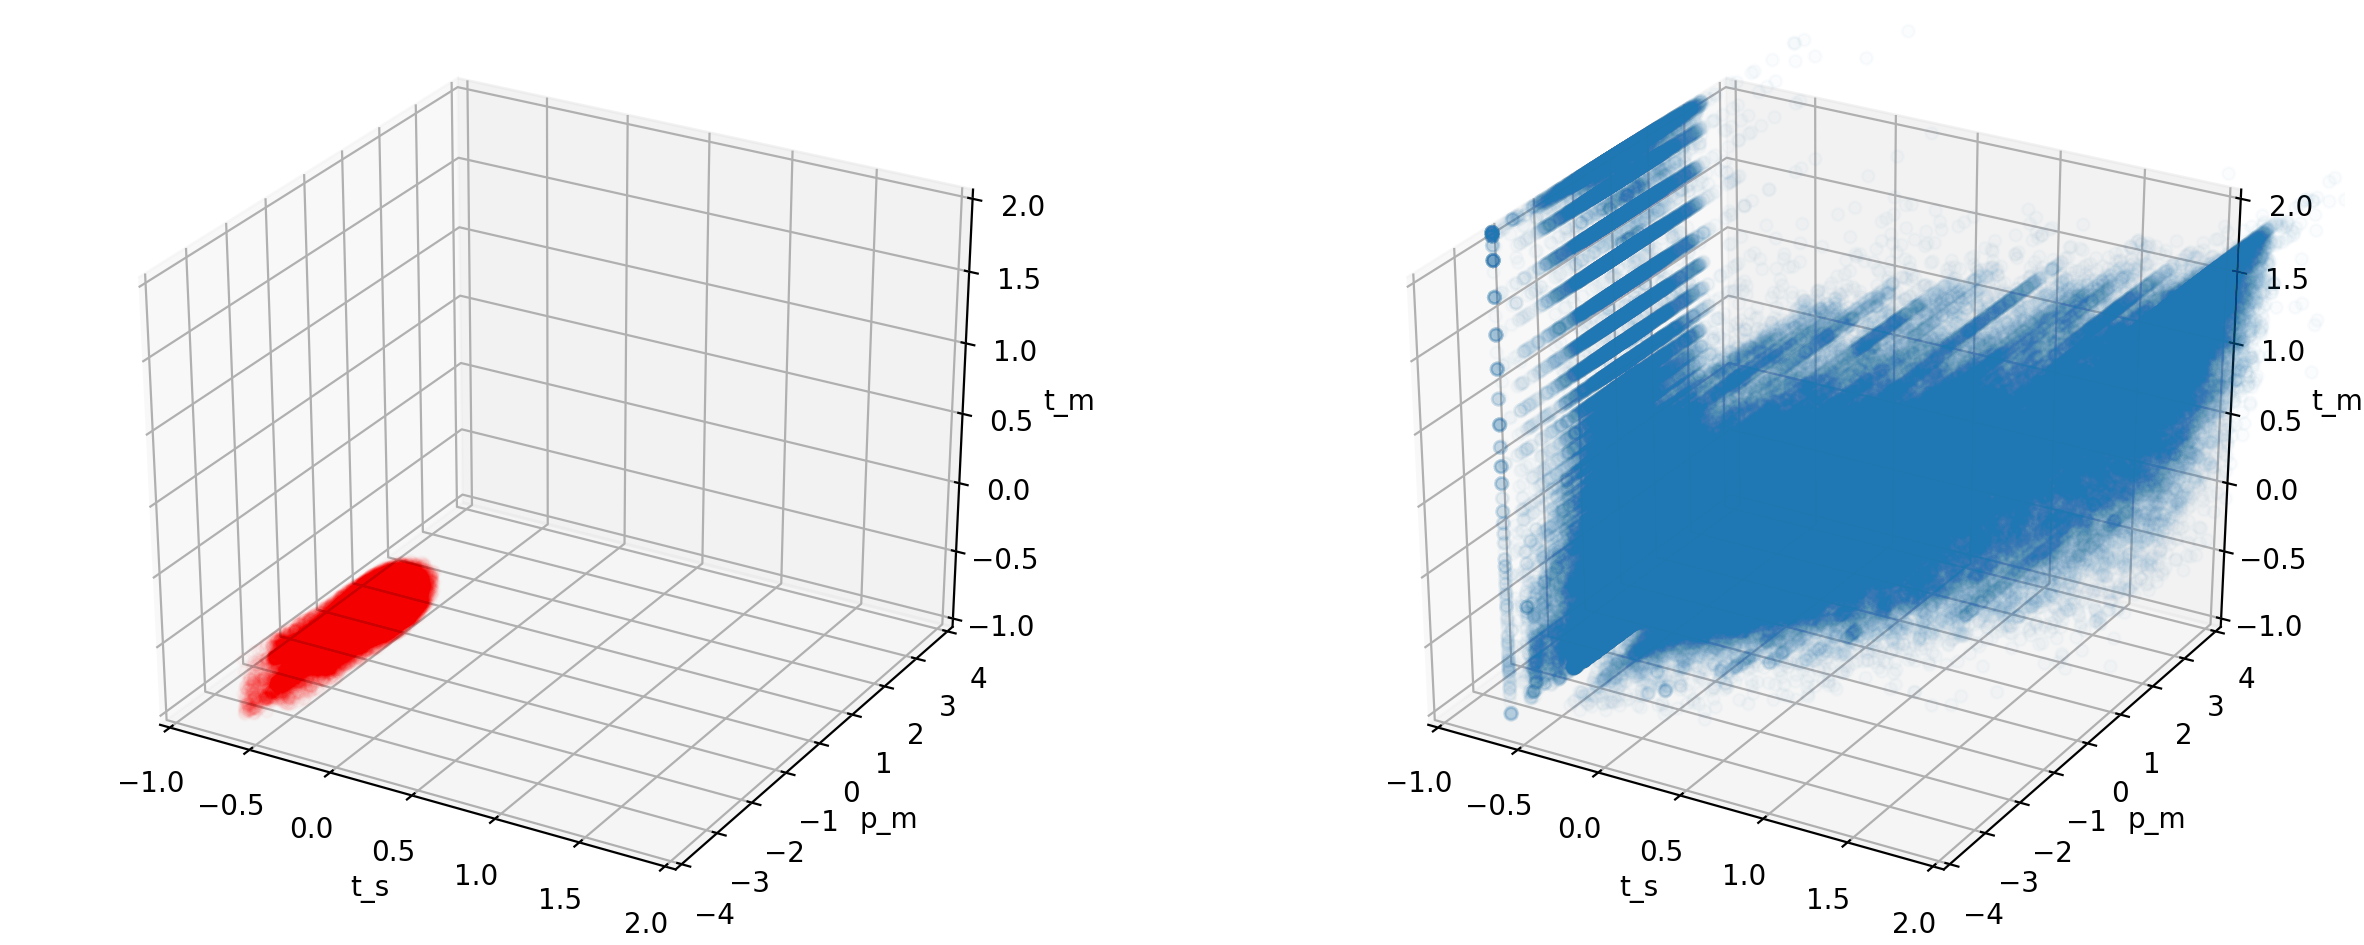

In [98]:
# Visual Inspection of ARM
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

p_d = pd.concat([pd.DataFrame(features, columns = ['t_m', 't_s', 'p_m']), 
                 result['arm_']], axis = 1)

# censor ARM classfied products with a to high price
result.loc[p_d['p_m'] > 0, 'arm_'] = 2
p_d.loc[p_d['p_m'] > 0, 'arm_'] = 2

# set arm condition
arm = p_d['arm_'] == 0

# plot LCA structure
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(xs = p_d[arm].t_s,
            ys = p_d[arm].p_m, 
            zs = p_d[arm].t_m,
            c  = 'red',
            alpha = .02)

ax1.set_xlim(-1, 2)
ax1.set_ylim(-4, 4)
ax1.set_zlim(-1, 2)

ax1.set_xlabel('t_s')
ax1.set_ylabel('p_m')
ax1.set_zlabel('t_m')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(xs = p_d[~arm].t_s,
            ys = p_d[~arm].p_m, 
            zs = p_d[~arm].t_m,
            c  = '#1f77b4',
            alpha = .02)

ax2.set_xlim(-1, 2)
ax2.set_ylim(-4, 4)
ax2.set_zlim(-1, 2)

ax2.set_xlabel('t_s')
ax2.set_ylabel('p_m')
ax2.set_zlabel('t_m')

plt.show()

In [99]:
if 'arm_bgm' in df: 
    df = df.drop('arm_bgm', axis = 1)

data = data.merge(result, on = levels, how = 'left')\
    .assign(arm_bgm = lambda x: x['arm_'].map({0 : True, 1 : False, 2: False}))\
    .drop('arm_', axis = 1)

In [101]:
stats.chi2_contingency(pd.crosstab(data.arm, data.arm_bgm))

(15080.538496623909, 0.0, 1, array([[247459.77995568,  33655.22004432],
        [ 10770.22004432,   1464.77995568]]))

# Aggregation (Vendor > Week)

In [102]:
select = {
    'mean': {
        'cols': ['rating', 'reputation', 'price_usd', 'delta_t',
                 'neg_rating'],
        'func': np.mean,
        'suff': '_m'},
    
    'min': {
        'cols': ['count', 'neg_count', 'pos_count'],
        'func': np.min,
        'suff': '_min'},
    
    'std': {
        'cols': ['price_usd', 'delta_t'],
        'func': np.std,
        'suff': '_s'},
    
    'fixed': {
        'cols': ['cum_count', 'arf', 'arf_bgm', 
                'neg_rating', 'international_shipment', 'item_count',
                'item_count_w', 'category_count', 'category_count_w'],
        'func': np.max,
        'suff': ''},
    
    # aggregate to vendor_week level data      
    'mean_w': {
        'cols': ['price_diff'],
        'func': np.mean, 
        'suff': '_mw'
    },
    
    'max_w': {
        'cols': ['arm', 'arm_bgm', 'empty_stock_last_week'],
        'func': np.max, 
        'suff': '_maxw'
    },
    
    'min_w': {
        'cols': ['me'],
        'func': np.min, 
        'suff': '_min'
    }
}

levels = ['vendor', 'w']

def aggregate_data(dfs = [f_df, data], levels = levels, select = select):
    # mutate columns with corresponding functions
    container = []
    for key in select.keys():
        if (key is not 'mean_w') & (key is not 'max_w') & (key is not 'min_w'):
            container.append(
                dfs[0].groupby(levels)\
                    [select[key]['cols']]\
                    .agg(select[key]['func'])\
                    .fillna(0)
                    .add_suffix(select[key]['suff']))
        else: 
            container.append(
                dfs[1].groupby(levels)\
                    [select[key]['cols']]\
                    .agg(select[key]['func'])\
                    .fillna(0)
                    .add_suffix(select[key]['suff']))
            

    # concatinate mutated columns
    data = pd.concat(container, axis = 1).reset_index()
    
    return data
    
vendor_week = aggregate_data()

In [103]:
vendor_week

vendor   w  rating_m  reputation_m  price_usd_m  delta_t_m  \
0           1   1  4.972222      0.000000   383.701916   0.128968   
1           1   2  4.750000     92.000000   318.790123   0.102941   
2           1   3  4.886364     92.000000   316.557890   0.159091   
3           1   4  4.833333      0.000000   174.886395   0.291667   
4           1   5  5.000000      0.000000   212.246140   0.388889   
...       ...  ..       ...           ...          ...        ...   
23677     905  37  5.000000     90.365256   477.589662   0.015590   
23678     905  38  5.000000     90.503165   681.074512   0.011076   
23679     905  39  5.000000     91.083200  1073.981117   0.011200   
23680     905  40  5.000000     92.334123  1012.092104   0.016588   
23681     905  41  5.000000     93.149068  1037.234590   0.012422   

       neg_rating_m  count_min  neg_count_min  pos_count_min  ...  \
0          0.119369          1            3.0           11.0  ...   
1          0.125021         37            5.0           45.0  ...   
2          0.134449        105           16.0          102.0  ...   
3          0.124132        149           19.0          143.0  ...   
4          0.114369        173           22.0          164.0  ...   
...             ...        ...            ...            ...  ...   
23677      0.001378       4122            6.0         4129.0  ...   
23678      0.001227       4571            6.0         4578.0  ...   
23679      0.001087       5203            6.0         5210.0  ...   
23680      0.000992       5828            6.0         5835.0  ...   
23681      0.000923       6250            6.0         6257.0  ...   

       international_shipment  item_count  item_count_w  category_count  \
0                       False           5             2               2   
1                       False           5             3               2   
2                       False           5             3               2   
3                       False           5             2               2   
4                       False           5             2               2   
...                       ...         ...           ...             ...   
23677                    True          82            36               5   
23678                    True          82            44               5   
23679                    True          82            41               5   
23680                    True          82            35               5   
23681                    True          82            35               5   

       category_count_w  price_diff_mw  arm_maxw  arm_bgm_maxw  \
0                     1       1.000000     False         False   
1                     2       0.849839     False         False   
2                     2       1.019123     False         False   
3                     1       0.694429     False         False   
4                     2       1.104530     False         False   
...                 ...            ...       ...           ...   
23677                 4       0.942673     False          True   
23678                 4       1.025121      True          True   
23679                 5       1.014440      True          True   
23680                 4       0.984017     False          True   
23681                 5       0.970033      True          True   

       empty_stock_last_week_maxw  me_min  
0                           False       1  
1                           False       2  
2                           False       3  
3                           False       4  
4                           False       5  
...                           ...     ...  
23677                       False      45  
23678                       False      46  
23679                       False      47  
23680                       False      48  
23681                       False      49  

[23682 rows x 26 columns]

In [104]:
vendor_week = vendor_week.sort_values(['vendor', 'w'])

vendor_week['neg_count_w'] = vendor_week\
    .groupby('vendor')\
    .apply(lambda x:  x['neg_count_min'] - x['neg_count_min'].shift(1))\
    .reset_index(drop = True)\
    .fillna(vendor_week['neg_count_min'])

vendor_week['pos_count_w'] = vendor_week\
    .groupby('vendor')\
    .apply(lambda x:  x['pos_count_min'] - x['pos_count_min'].shift(1))\
    .reset_index(drop = True)\
    .fillna(vendor_week['pos_count_min'])

In [105]:
diff_cut = vendor_week.loc[vendor_week['price_diff_mw'] > 0\
                & (~vendor_week['price_diff_mw'].isin([np.inf, -np.inf])), 
                'price_diff_mw'].quantile(.10)

price_diff = vendor_week.loc[vendor_week['price_diff_mw'] > 0\
                & (~vendor_week['price_diff_mw'].isin([np.inf, -np.inf])), 
                'price_diff_mw']

In [106]:
vendor_week.loc[vendor_week['price_diff_mw'] > 0\
                & (~vendor_week['price_diff_mw'].isin([np.inf, -np.inf])), 
                'has_price_drop']\
    = price_diff < diff_cut

vendor_week['has_price_drop'] = vendor_week['has_price_drop'].fillna(False)

In [107]:
vendor_week.loc[vendor_week['price_diff_mw'].isin([np.inf]), 'price_diff_mw'] = None
vendor_week['sales_volume_w'] = vendor_week.groupby('vendor').apply(lambda x: x['count_min'] - x['count_min'].shift(1)).reset_index(drop = True)
vendor_week['arm_maxw_shift'] = vendor_week.groupby('vendor').apply(lambda x: x['arm_maxw'].shift(1)).reset_index(drop = True).astype('bool')
vendor_week['arm_bgm_maxw_shift'] = vendor_week.groupby('vendor').apply(lambda x: x['arm_bgm_maxw'].shift(1)).reset_index(drop = True).astype('bool')
vendor_week['has_price_drop_shift'] = vendor_week.groupby('vendor').apply(lambda x: x['has_price_drop'].shift(1)).reset_index(drop = True).astype('bool')
shift = ['has_price_drop_shift', 'arm_bgm_maxw_shift', 'arm_maxw_shift']
vendor_week = vendor_week.dropna(subset = shift).reset_index(drop = True)

In [108]:
vendor_week

vendor   w  rating_m  reputation_m  price_usd_m  delta_t_m  \
0           1   1  4.972222      0.000000   383.701916   0.128968   
1           1   2  4.750000     92.000000   318.790123   0.102941   
2           1   3  4.886364     92.000000   316.557890   0.159091   
3           1   4  4.833333      0.000000   174.886395   0.291667   
4           1   5  5.000000      0.000000   212.246140   0.388889   
...       ...  ..       ...           ...          ...        ...   
23677     905  37  5.000000     90.365256   477.589662   0.015590   
23678     905  38  5.000000     90.503165   681.074512   0.011076   
23679     905  39  5.000000     91.083200  1073.981117   0.011200   
23680     905  40  5.000000     92.334123  1012.092104   0.016588   
23681     905  41  5.000000     93.149068  1037.234590   0.012422   

       neg_rating_m  count_min  neg_count_min  pos_count_min  ...  \
0          0.119369          1            3.0           11.0  ...   
1          0.125021         37            5.0           45.0  ...   
2          0.134449        105           16.0          102.0  ...   
3          0.124132        149           19.0          143.0  ...   
4          0.114369        173           22.0          164.0  ...   
...             ...        ...            ...            ...  ...   
23677      0.001378       4122            6.0         4129.0  ...   
23678      0.001227       4571            6.0         4578.0  ...   
23679      0.001087       5203            6.0         5210.0  ...   
23680      0.000992       5828            6.0         5835.0  ...   
23681      0.000923       6250            6.0         6257.0  ...   

       arm_bgm_maxw  empty_stock_last_week_maxw  me_min  neg_count_w  \
0             False                       False       1          3.0   
1             False                       False       2          2.0   
2             False                       False       3         11.0   
3             False                       False       4          3.0   
4             False                       False       5          3.0   
...             ...                         ...     ...          ...   
23677          True                       False      45          0.0   
23678          True                       False      46          0.0   
23679          True                       False      47          0.0   
23680          True                       False      48          0.0   
23681          True                       False      49          0.0   

       pos_count_w  has_price_drop  sales_volume_w  arm_maxw_shift  \
0             11.0           False             NaN            True   
1             34.0            True            36.0           False   
2             57.0           False            68.0           False   
3             41.0            True            44.0           False   
4             21.0           False            24.0           False   
...            ...             ...             ...             ...   
23677        516.0           False           516.0            True   
23678        449.0           False           449.0           False   
23679        632.0           False           632.0            True   
23680        625.0           False           625.0            True   
23681        422.0           False           422.0           False   

       arm_bgm_maxw_shift  has_price_drop_shift  
0                    True                  True  
1                   False                 False  
2                   False                  True  
3                   False                 False  
4                   False                  True  
...                   ...                   ...  
23677                True                 False  
23678                True                 False  
23679                True                 False  
23680                True                 False  
23681                True                 False  

[23682 rows x 33 columns]

# Data Summary

In [109]:
vendor_week\
    [['arm_maxw', 'has_price_drop', 'neg_count_min', 'neg_count_w', 'pos_count_min', 'neg_count_w', 
      'item_count_w', 'international_shipment', 'empty_stock_last_week_maxw', 
      'international_shipment', 'w', 'me_min']]\
    .astype({'has_price_drop': int,
             'empty_stock_last_week_maxw': int,
             'arm_maxw': int,
             'international_shipment': int})\
    .describe()\
    .applymap('{:.3f}'.format)\
    .T[['count', 'mean', 'std', 'min', 'max']]

count      mean       std    min         max
arm_maxw                    23682.000     0.043     0.203  0.000       1.000
has_price_drop              23682.000     0.100     0.300  0.000       1.000
neg_count_min               23682.000    65.624   241.658  1.000    3960.000
neg_count_w                 23682.000     3.262    17.602  0.000     869.000
pos_count_min               23682.000  2084.091  8208.451  1.000  312104.000
neg_count_w                 23682.000     3.262    17.602  0.000     869.000
item_count_w                23682.000    12.685    31.557  1.000     628.000
international_shipment      23682.000     0.637     0.481  0.000       1.000
empty_stock_last_week_maxw  23682.000     0.102     0.303  0.000       1.000
international_shipment      23682.000     0.637     0.481  0.000       1.000
w                           23682.000    19.873    12.994  1.000      51.000
me_min                      23682.000    25.035    13.035  1.000      50.000

In [110]:
data\
    [['vendor', 'arf', 'category_count', 'item_count']]\
    .astype({'arf' : int})\
    .groupby('vendor')\
    .mean()\
    .describe()\
    .applymap('{:.3f}'.format)\
    .T[['count', 'mean', 'std', 'min', 'max']]

count    mean     std    min      max
arf             905.000   0.048   0.213  0.000    1.000
category_count  905.000   3.272   1.817  1.000   10.000
item_count      905.000  27.501  47.399  1.000  731.000

# Export File

In [111]:
PATH = "/Volumes/Extreme SSD/data/analysis"

vendor_week.to_pickle(os.path.join(PATH, 'vendor_week.pickle'))
vendor_week.replace([True, False], [1, 0]).to_csv(os.path.join(PATH, 'vendor_week.csv'))